# **Preparación de Dataset para problemas de Regresión**
**EDA, Data Wrangling, Cleaning y Feature Engineering**

##INTRODUCCIÓN##
A partir de datos sobre ofertas de propiedades en venta y alquiler correspondientes al primer semestre de 2017 publicados por la inmobiliaria Properati, buscaremos desarrollar un modelo de regresión que permita predecir el precio por metro cuadrado de las propiedades. 
Para ello, este trabajo tendrá por objetivo:

* Realizar un análisis descriptivo de las principales variables.
* Efectuar una limpieza del dataset provisto, diseñando estrategias para lidiar con los datos perdidos en ciertas variables.
* Crear nuevas columnas a partir de las características dadas que puedan tener valor predictivo.

--------------------------------------------------------





In [ ]:
# Conectamos a drive para utilizar el dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
# Instalamos geopandas para graficar datos geolocalizados
!pip install geopandas
!pip install rtree

In [ ]:
# Imports de librerías necesarias para el trabajo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import os.path
import geopandas as gpd
import rtree


# Mostrar todas las columnas y filas al ver el dataset
pd.options.display.max_columns = None
pd.options.display.max_rows = None


Antes de comenzar el trabajo, convertimos el dataset al formato `parquet`.
Permite reducir tanto el tamaño del dataset en disco como el tiempo para cargarlo.
Pero lo más importante, es que nos permite mantener las asignaciones correctas de `dtypes`, algo que el formato `csv` no posibilita.

*Fuente*: https://www.youtube.com/watch?v=u4rsA5ZiTls

**OPCIONAL** para trabajar con `csv` se puede setear la variable `crear_parquet` como False


In [ ]:
ubicacion_dataset = '/content/drive/MyDrive/TP 1 - GRUPO 5/'
crear_parquet = True

Luego de ejecutar los imports, se puede pasar a diferentes secciones de la notebook, en caso de ya haber sido ejecutada:

- 1er paso intermedio: luego del análisis y 1ra limpieza, sin imputación

https://colab.research.google.com/drive/1TyCfcZHPUjUn1hV-gTgeoE5VlPra9tdG#scrollTo=Xq9jZ021AeuJ&line=1&uniqifier=1

- 2do paso intermedio: luego de la imputación de LAT y LON

https://colab.research.google.com/drive/1TyCfcZHPUjUn1hV-gTgeoE5VlPra9tdG#scrollTo=2nCl0tRWJHKz&line=1&uniqifier=1


En caso contrario, ejecutar la notebook en orden



In [ ]:
if crear_parquet:
  if not os.path.isfile(f'{ubicacion_dataset}properati.parquet'):
    data = pd.read_csv(f'{ubicacion_dataset}properati.csv', index_col = 0)
    data.to_parquet(f'{ubicacion_dataset}properati.parquet')
  else:
    data = pd.read_parquet(f'{ubicacion_dataset}properati.parquet')
else:
  data = pd.read_csv(f'{ubicacion_dataset}properati.csv', index_col = 0)

##**PRIMER ACERCAMIENTO A LOS DATOS**

-------------------------------

En esta sección de la *notebook* realizamos una vista previa del data_set. Identificando, la dimensión del dataset, la información que contiene cada columna, el tipo de dato, cantidad de no nulos por columna.

###**Vemos que hay en el dataset**

In [ ]:
display(data.head(10))

operation property_type    place_name  \
0      sell            PH     Mataderos   
1      sell     apartment      La Plata   
2      sell     apartment     Mataderos   
3      sell            PH       Liniers   
4      sell     apartment        Centro   
5      sell         house  Gualeguaychú   
6      sell            PH         Munro   
7      sell     apartment      Belgrano   
8      sell     apartment      Belgrano   
9      sell         house       Rosario   

                             place_with_parent_names country_name  \
0              |Argentina|Capital Federal|Mataderos|    Argentina   
1        |Argentina|Bs.As. G.B.A. Zona Sur|La Plata|    Argentina   
2              |Argentina|Capital Federal|Mataderos|    Argentina   
3                |Argentina|Capital Federal|Liniers|    Argentina   
4  |Argentina|Buenos Aires Costa Atlántica|Mar de...    Argentina   
5                |Argentina|Entre Ríos|Gualeguaychú|    Argentina   
6  |Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...    Argentina   
7               |Argentina|Capital Federal|Belgrano|    Argentina   
8               |Argentina|Capital Federal|Belgrano|    Argentina   
9                       |Argentina|Santa Fe|Rosario|    Argentina   

                     state_name  geonames_id                  lat-lon  \
0               Capital Federal    3430787.0  -34.6618237,-58.5088387   
1        Bs.As. G.B.A. Zona Sur    3432039.0  -34.9038831,-57.9643295   
2               Capital Federal    3430787.0  -34.6522615,-58.5229825   
3               Capital Federal    3431333.0  -34.6477969,-58.5164244   
4  Buenos Aires Costa Atlántica    3435548.0  -38.0026256,-57.5494468   
5                    Entre Ríos    3433657.0   -33.0140714,-58.519828   
6      Bs.As. G.B.A. Zona Norte    3430511.0  -34.5329567,-58.5217825   
7               Capital Federal    3436077.0   -34.5598729,-58.443362   
8               Capital Federal    3436077.0   -34.5598729,-58.443362   
9                      Santa Fe    3838574.0   -32.942031,-60.7259192   

         lat        lon     price currency  price_aprox_local_currency  \
0 -34.661824 -58.508839   62000.0      USD                  1093959.00   
1 -34.903883 -57.964330  150000.0      USD                  2646675.00   
2 -34.652262 -58.522982   72000.0      USD                  1270404.00   
3 -34.647797 -58.516424   95000.0      USD                  1676227.50   
4 -38.002626 -57.549447   64000.0      USD                  1129248.00   
5 -33.014071 -58.519828       NaN     None                         NaN   
6 -34.532957 -58.521782  130000.0      USD                  2293785.00   
7 -34.559873 -58.443362  138000.0      USD                  2434941.00   
8 -34.559873 -58.443362  195000.0      USD                  3440677.50   
9 -32.942031 -60.725919  460000.0      ARS                   455201.45   

   price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
0         62000.00                 55.0                   40.0   
1        150000.00                  NaN                    NaN   
2         72000.00                 55.0                   55.0   
3         95000.00                  NaN                    NaN   
4         64000.00                 35.0                   35.0   
5              NaN                 53.0                    NaN   
6        130000.00                106.0                   78.0   
7        138000.00                 45.0                   40.0   
8        195000.00                 65.0                   60.0   
9         25798.49                  NaN                    NaN   

   price_usd_per_m2  price_per_m2  floor  rooms  expenses  \
0       1127.272727   1550.000000    NaN    NaN       NaN   
1               NaN           NaN    NaN    NaN       NaN   
2       1309.090909   1309.090909    NaN    NaN       NaN   
3               NaN           NaN    NaN    NaN       NaN   
4       1828.571429   1828.571429    NaN    NaN       NaN   
5               NaN           NaN    NaN    NaN       Na

**Información sobre las columnas, cantidad de no-nulos y dtype**

In [ ]:
rows_data = data.shape[0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   operation                   121220 non-null  object 
 1   property_type               121220 non-null  object 
 2   place_name                  121197 non-null  object 
 3   place_with_parent_names     121220 non-null  object 
 4   country_name                121220 non-null  object 
 5   state_name                  121220 non-null  object 
 6   geonames_id                 102503 non-null  float64
 7   lat-lon                     69670 non-null   object 
 8   lat                         69670 non-null   float64
 9   lon                         69670 non-null   float64
 10  price                       100810 non-null  float64
 11  currency                    100809 non-null  object 
 12  price_aprox_local_currency  100810 non-null  float64
 13  price_aprox_us

------------------------------------------------------------------
Con esto podemos ver que nuestro dataset contiene inicialmente ``121220`` filas y ``25`` columnas con la siguiente información:

* ``operation`` indica qué tipo de operación se realizo en la propiedad, donde el resultado siempre es ``venta``.
* ``property_type`` indica si la propiedad en cuestión es una departamento, una casa, un PH.
* ``place_name`` muestra la localidad donde está ubicada la propiedad
* ``place_name_with_parent_names`` en esta columna se agrega la información sobre la localidad, provincia y país donde se ubica la propiedad.
* ``country_name`` en esta columna el único valor es ``Argentina``
* ``state_name`` la provincia donde está ubicada la propiedad. 
* ``geonames_id`` es un codigo de indentificación de la geolocalzación de la propiedad.
* ``lat-lon`` indica las coordendas donde está ubicada la propiedad.
* ``lat`` 
* ``lon`` 
* ``price`` el precio de la propiedad expresado en la moneda que se indica en la columna ``currency``
* ``currency`` la moneda en la cual está expresado el precio (price) de la propiedad.
* ``price_aprox_local_currency`` el precio de la propiedad en moneda local.
* ``price_aprox_usd`` el precio de la propiedad expresado en USD.
* ``surface_total_in_m2`` describe el total metros cuadrados de la propiedad.
* ``surface_covered_in_m2`` describe la superficie cubierta de la propiedad en metros cuadrados.
* ``price_usd_per_m2`` el precio en USD por metro cuadrado total de la propiedad.
* ``price_per_m2`` el precio en USD por metro cuadrado cubierto.
* ``floor`` el número de plantas que posee la propiedad si es casa, o el piso en el que está ubicada la propiedad en el edificio si esta es apartamento.
* ``rooms`` la cantidad de habitaciones que tiene la propiedad.
* ``expenses`` monto que se paga por expensas por la propiedad ---> en la moneda que se expresa en la columna ``currency``.
* ``properati_url`` aquí se indica la dirección url para ver la publicación de la propiedad en la página web de la inmobiliaria properati.
* ``description`` aquí se encuentra una descripción de la propiedad, donde se detalla la cantidad de ambientes, el piso del departamento, las platas de la casa, si posee patio, el monto de expensas que se paga, etc.
* ``title`` se presenta un título de la propiedad donde se da un detalle muy resumido de las características de la misma.
* ``image_thumbnail`` se ofrece una imagen la propiedad.




---


Para homogeneizar los datos, pasamos a mayuscula los nombres de las columnas y los datos tipo string a minuscula

In [ ]:
data.columns = map(str.upper, data.columns)
#change to lower case the columns title and description
data['TITLE'] = data['TITLE'].str.lower()
data['DESCRIPTION'] = data['DESCRIPTION'].str.lower()


## **ANÁLISIS EXPLORATORIO**

**Vamos a observar cómo esta conformado el dataset y sus principales variables.**

Revisamos las columnas OPERATION y COUNTRY NAME, ya que en el head parecieran tener siempre los mismos valores

In [ ]:
print(f"La columna OPERATION tiene los siguientes valores:\n {data['OPERATION'].value_counts()}")
print('---------------------------------------------------')
print(f"La columna COUNTRY_NAME tiene los siguientes valores:\n {data['COUNTRY_NAME'].value_counts()}")
print('---------------------------------------------------')

La columna OPERATION tiene los siguientes valores:
 sell    121220
Name: OPERATION, dtype: int64
---------------------------------------------------
La columna COUNTRY_NAME tiene los siguientes valores:
 Argentina    121220
Name: COUNTRY_NAME, dtype: int64
---------------------------------------------------


Vemos que cuentan con un único valor, por lo que procedemos a quitarlas. También nos deshacemos de la columna de IMAGE_THUMBNAIL, ya que en esos links no aportan información faltante al dataset, y extraer otro tipo de información desde las imágenes excede las pautas de este trabajo. Como tarea a futuro, se podrían aplicar modelos de redes neuronales para ver posibles relaciones entre las imágenes y el precio de la propiedad.

In [ ]:
data=data.drop(['OPERATION', 'COUNTRY_NAME', 'IMAGE_THUMBNAIL'], axis=1)



---


Observamos que `PROPERTY_TYPE` tiene solo 4 categorías , sin valores faltantes

In [ ]:
data.PROPERTY_TYPE.value_counts(dropna = False)

apartment    71065
house        40268
PH            5751
store         4136
Name: PROPERTY_TYPE, dtype: int64

Procedemos a transformarla en categorica, para optimizar las operaciones que involucren esta variable

In [ ]:
data.PROPERTY_TYPE = data.PROPERTY_TYPE.astype('category')

Y graficamos para observar mejor la distribución

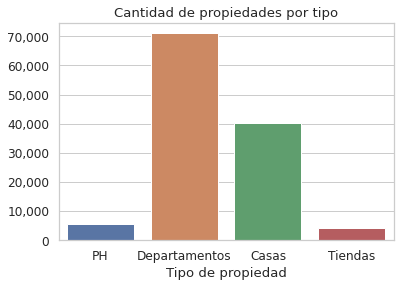

In [ ]:
sns.set(style = 'whitegrid', palette = 'deep', font_scale = 1.1)
ax = sns.countplot(x = data.PROPERTY_TYPE)

ax.set_title('Cantidad de propiedades por tipo')
ax.set_xlabel('Tipo de propiedad')
ax.set_ylabel('')
current_values = plt.gca().get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
ax.set_xticklabels(['PH', 'Departamentos', 'Casas', 'Tiendas'])
plt.show()

Se observa una predominancia marcada de Departamentos en el dataset, seguido por Casas con casi la mitad de filas. Por su parte, PH y Tiendas tienen comparativamente poca representación, pero aun así pueden ser significativas a la hora de aplicar modelos de regresión.


---



### **Distribución por provincia**
Se trata de un dataset con geolocalización y este será seguramente un punto importante a la hora de mirar los datos y luego implementar un modelo para predecir precios.

Observamos la distribución por provincias

In [ ]:
data_states = pd.DataFrame(data.STATE_NAME.value_counts())
data_states.columns = ['CANTIDAD']
data_states['PORCENTAJE'] = data_states.CANTIDAD / rows_data * 100

valores_bsas = data_states[data_states.index.isin(['Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur',
                                                                               'Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Oeste', 
                                                                               'Buenos Aires Interior'])].sum()
valores_bsas = pd.DataFrame(valores_bsas).transpose().rename(index = {0: 'Buenos Aires'})
data_states = data_states.append(valores_bsas).drop(['Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur',
                                                                               'Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Oeste', 
                                                                               'Buenos Aires Interior'])

data_states = data_states.sort_values(by = 'PORCENTAJE', ascending = False)
data_states

CANTIDAD  PORCENTAJE
Buenos Aires          61131.0   50.429797
Capital Federal       32316.0   26.658967
Córdoba               12069.0    9.956278
Santa Fe              10172.0    8.391355
Río Negro               808.0    0.666557
Neuquén                 733.0    0.604686
Mendoza                 681.0    0.561788
Tucumán                 674.0    0.556014
Corrientes              583.0    0.480944
Misiones                464.0    0.382775
Entre Ríos              369.0    0.304405
Salta                   278.0    0.229335
Chubut                  259.0    0.213661
San Luis                252.0    0.207886
La Pampa                157.0    0.129517
Formosa                  65.0    0.053622
Chaco                    57.0    0.047022
San Juan                 40.0    0.032998
Tierra Del Fuego         31.0    0.025573
Catamarca                27.0    0.022274
Jujuy                    26.0    0.021449
Santa Cruz               20.0    0.016499
Santiago Del Estero       4.0    0.003300
La Rioja                  4.0    0.003300

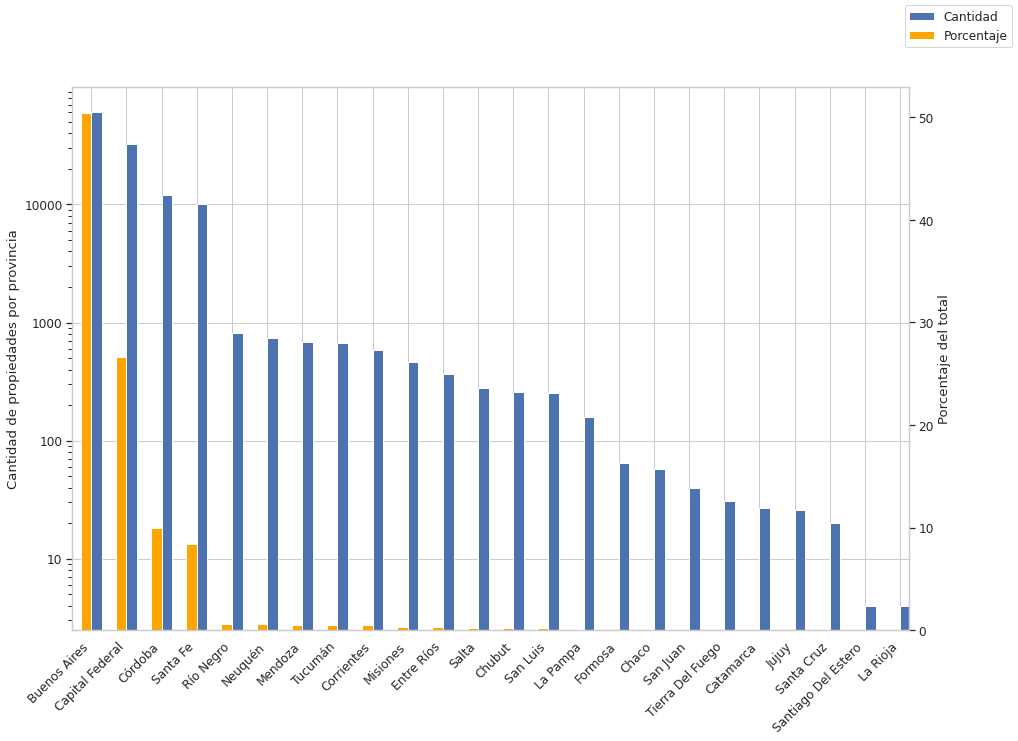

In [ ]:
fig, ax = plt.subplots()
width = .3
data_states.CANTIDAD.plot(ax = ax, kind = 'bar', figsize = (15,10), logy = True, rot = 45, width = width, position = 0, label = 'Cantidad')
ax.set_xticklabels(ax.get_xticklabels(), ha = 'right')
ax.set_yticklabels(['','', '10', '100', '1000', '10000'])
ax.set_ylabel('Cantidad de propiedades por provincia')

ax2 = ax.twinx()

data_states.PORCENTAJE.plot(ax = ax2, kind = 'bar', color = 'orange', width =  width, position = 1, label = 'Porcentaje')
ax2.set_ylabel('Porcentaje del total')
ax2.grid(visible = False, which = 'both', axis = 'y')

fig.legend()

plt.show()

Como se puede observar, Capital Federal, Buenos Aires (que incluye diversas sub-zonas), Córdoba y Santa Fe cuentan con gran parte de los datos. Solo Provincia de Buenos Aires ya cuenta con la mitad del dataset total. En proporción, todo el resto pareciera estar sub-representado.

Sin embargo esto puede tener una explicación diferente a la mera sobre-representación de algunas provincias. Observemos la proporción de propiedades respecto a la población de cada provincia, tomando a esta última como un posible proxy del tamaño del mercado inmobiliario (para simplificar la búsqueda de información). 
Para esto vamos a scrapear algunos datos del Instituto Geográfico Nacional, referidos a la población estimada para el año 2015.
En base a esto, calculamos el porcentaje de población para cada provincia.

In [ ]:
# Scrapeamos y limpiamos la tabla
data_poblacion = pd.read_html('http://www.ign.gob.ar/NuestrasActividades/Geografia/DatosArgentina/Poblacion2',  attrs={'class': "table table-striped pob2020"})
data_poblacion = data_poblacion[0].set_index('Jurisdicción').drop(['Año 2010', 'Año 2020'], axis = 1)
# Hecho en octubre 2022. Revisar si el orden del index continua siendo el mismo!
data_poblacion.index = ['Total', 'Capital Federal',
       'Buenos Aires', 'Catamarca', 'Chaco', 'Chubut', 'Córdoba', 'Corrientes',
       'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza',
       'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis',
       'Santa Cruz', 'Santa Fe', 'Santiago Del Estero',
       'Tierra Del Fuego', 'Tucumán']
data_poblacion.columns = ['POB_2015']
data_poblacion.POB_2015 = data_poblacion.POB_2015.str.replace('.', '', regex = False)
data_poblacion.POB_2015 = pd.to_numeric(data_poblacion.POB_2015)

# Calculamos el porcentaje para cada provincia
pob_total = data_poblacion.POB_2015[data_poblacion.index == 'Total'].values
data_poblacion['PORCENTAJE_POB'] = data_poblacion.POB_2015 / pob_total * 100

data_poblacion = data_poblacion.sort_values(by = 'PORCENTAJE_POB', ascending = False)

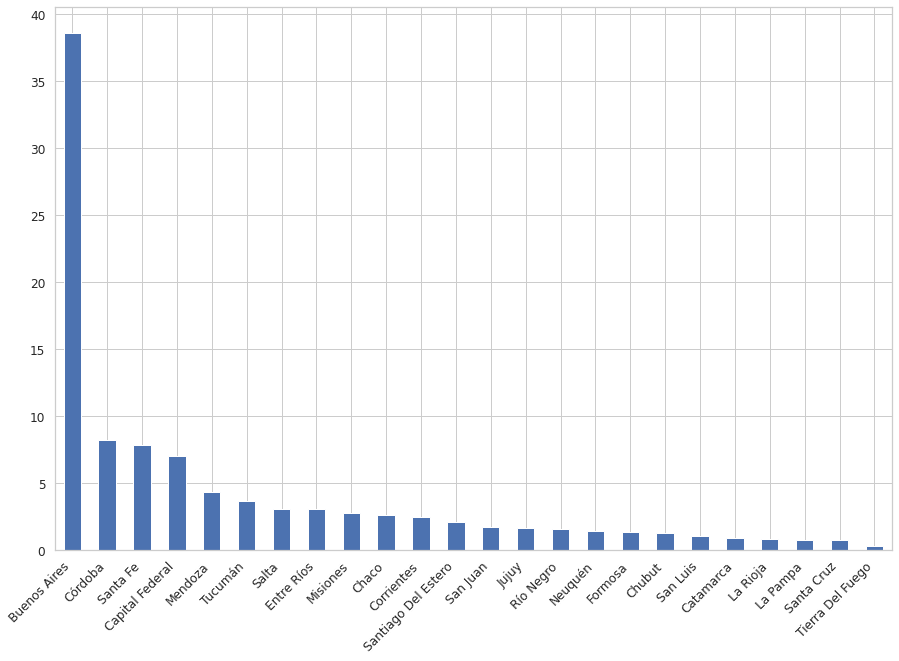

In [ ]:
ax = data_poblacion.PORCENTAJE_POB.drop('Total', axis = 0).sort_values(ascending = False).plot(kind = 'bar', figsize = (15,10), rot = 45)
ax.set_xticklabels(ax.get_xticklabels(), ha = 'right')
plt.show()

Como se puede observar, la provincia de Buenos Aires cuenta con gran parte de la población del país. Esto explicaría, por lo menos en parte, la proporción de propiedades pertenecientes a esta provincia.
Intentemos volver a graficar el peso de las propiedades, ponderado según su porcentaje de población

In [ ]:
data_pond = data_states.drop('CANTIDAD', axis = 1).join(data_poblacion).drop('POB_2015', axis = 1)
data_pond['REPRESENTACION'] = data_pond.PORCENTAJE / data_pond.PORCENTAJE_POB - 1
data_pond = data_pond.sort_values(by = 'REPRESENTACION', ascending = False)

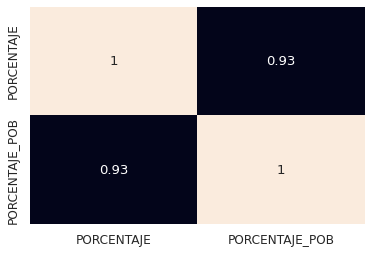

In [ ]:
corr_porcentajes = data_pond.loc[:,'PORCENTAJE':'PORCENTAJE_POB'].corr()
sns.heatmap(corr_porcentajes, annot = True, cbar = False)

plt.show()

Se observa una correlación significativa entre el peso de cada provincia en el dataset y su porcentaje de población

In [ ]:
data_pond['PESO_DATASET'] = data_pond.PORCENTAJE.map('{:.4f}%'.format)
data_pond['PORCENTAJE_POBLACION'] = data_pond.PORCENTAJE_POB.map('{:.4f}%'.format)

data_pond.loc[:,['PESO_DATASET', 'PORCENTAJE_POBLACION', 'REPRESENTACION']]


PESO_DATASET PORCENTAJE_POBLACION  REPRESENTACION
Capital Federal         26.6590%              7.0812%        2.764745
Buenos Aires            50.4298%             38.6255%        0.305609
Córdoba                  9.9563%              8.2715%        0.203687
Santa Fe                 8.3914%              7.8771%        0.065290
Neuquén                  0.6047%              1.4369%       -0.579161
Río Negro                0.6666%              1.6203%       -0.588625
Corrientes               0.4809%              2.4814%       -0.806182
San Luis                 0.2079%              1.1044%       -0.811766
La Pampa                 0.1295%              0.7954%       -0.837161
Chubut                   0.2137%              1.3144%       -0.837445
Tucumán                  0.5560%              3.6930%       -0.849443
Misiones                 0.3828%              2.7577%       -0.861197
Mendoza                  0.5618%              4.3716%       -0.871491
Entre Ríos               0.3044%              3.0637%       -0.900640
Salta                    0.2293%              3.0914%       -0.925814
Tierra Del Fuego         0.0256%              0.3531%       -0.927583
Formosa                  0.0536%              1.3430%       -0.960072
Catamarca                0.0223%              0.9202%       -0.975795
Santa Cruz               0.0165%              0.7430%       -0.977794
San Juan                 0.0330%              1.7133%       -0.980740
Chaco                    0.0470%              2.6505%       -0.982259
Jujuy                    0.0214%              1.6873%       -0.987288
La Rioja                 0.0033%              0.8526%       -0.996130
Santiago Del Estero      0.0033%              2.1518%       -0.998466

Esta correlación se refleja en que gran parte de las provincias no tienen una elevada variabilidad en su representación dentro del dataset. Destaca si el caso de Capital Federal, con una marcada sobre-representación respecto al resto. Esto podría explicarse por otros factores que llevan a una sobredimensión de ese mercado inmobiliario (por ejemplo, una mayor demanda de monoambientes vinculada a más personas que viven solas; o mayor densidad poblacional).



---

### **Geolocalización**

Llevamos el dataset a **Geopandas** para poder trabajar con datos geolocalizados

In [ ]:
# Creamos el GeoDataFrame utilizando las coordenadas para crear puntos en la columna de Geometry
data_geo = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(x = data.LON, y = data.LAT), crs = 'EPSG:4326')

Y luego graficamos rápidamente las propiedades en un mapa de Argentina para observar los datos

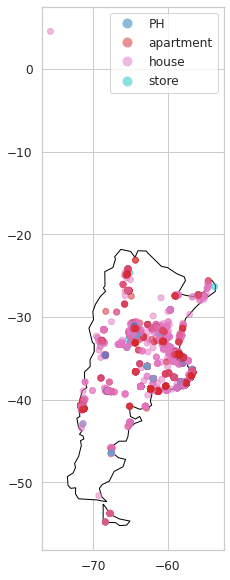

In [ ]:
# Importamos el contorno del mundo en baja resolución
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Nos restringimos a Argentina
ax = world[world.name == 'Argentina'].plot(color='white', edgecolor='black', figsize = (10,10))

# Ploteamos los puntos
data_geo.plot(ax=ax, column = 'PROPERTY_TYPE', legend = True, alpha = 0.5)

plt.show()

Observamos un outlier, aparentemente ubicado en otra parte del continente.
Volvemos a plotear pero utilizando un mapa de toda América del Sur, para ver si logramos identificar la ubicación.

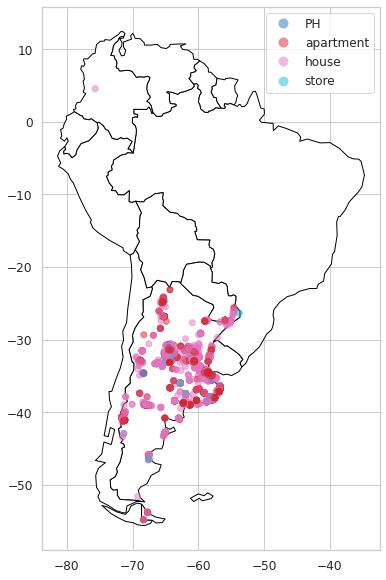

In [ ]:
# Nos restringimos a América del Sur
ax = world[world.continent == 'South America'].plot(color='white', edgecolor='black', figsize = (10,10))

# Ploteamos los puntos
data_geo.plot(ax=ax, column = 'PROPERTY_TYPE', legend = True, alpha = 0.5)

plt.show()

Esta propiedad pareciera estar ubicada en Colombia. La observamos en detalle

In [ ]:
outlier_loc = data[data.LAT > 0]
display(outlier_loc)
print(outlier_loc.DESCRIPTION.values, outlier_loc.TITLE.values)

PROPERTY_TYPE PLACE_NAME PLACE_WITH_PARENT_NAMES STATE_NAME  GEONAMES_ID  \
9761         house    Córdoba     |Argentina|Córdoba|    Córdoba    3860255.0   

                     LAT-LON       LAT        LON  PRICE CURRENCY  \
9761  4.5458426,-75.67893099  4.545843 -75.678931    0.0     None   

      PRICE_APROX_LOCAL_CURRENCY  PRICE_APROX_USD  SURFACE_TOTAL_IN_M2  \
9761                         0.0              0.0                  NaN   

      SURFACE_COVERED_IN_M2  PRICE_USD_PER_M2  PRICE_PER_M2  FLOOR  ROOMS  \
9761                    NaN               NaN           NaN    2.0    3.0   

      EXPENSES                                      PROPERATI_URL  \
9761       NaN  http://www.properati.com.ar/165i3_venta_casa_c...   

                              DESCRIPTION  \
9761  casa en venta de 2 dorm. en armenia   

                                      TITLE                   geometry  
9761  se vende casa en el barrio el limonar  POINT (-75.67893 4.54584)

['casa en venta de 2 dorm. en armenia'] ['se vende casa en el barrio el limonar']


Por la descripción y la geolocalización, parece tratarse de una propiedad en Barrio El Limonar en Armenia, Colombia. Por otra parte la propiedad no cuenta con datos de precio y superficie. Procedemos a eliminarla del dataset

In [ ]:
data = data.drop(outlier_loc.index)
data_geo = data_geo.drop(outlier_loc.index)

Volvemos a plotear, marcando las provincias y separando por tipo de propiedad

In [ ]:
# Buscamos archivo .shp de provincias de Argentina
!wget https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.34/download/provincias.zip
!unzip provincias.zip

--2022-10-25 21:39:26--  https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.34/download/provincias.zip
Resolving infra.datos.gob.ar (infra.datos.gob.ar)... 186.33.215.176
Connecting to infra.datos.gob.ar (infra.datos.gob.ar)|186.33.215.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10497796 (10M) [application/zip]
Saving to: ‘provincias.zip’

provincias.zip      100%[===================>]  10.01M  6.85MB/s    in 1.5s    

2022-10-25 21:39:28 (6.85 MB/s) - ‘provincias.zip’ saved [10497796/10497796]

Archive:  provincias.zip
   creating: provincias/
  inflating: provincias/provincias.dbf  
  inflating: provincias/provincias.shx  
  inflating: provincias/provincias.cpg  
  inflating: provincias/provincias.shp  
  inflating: provincias/provincias.prj  


In [ ]:
# Cargamos el dataset con datos de provincias
prov_geo = gpd.read_file('./provincias/provincias.shp')

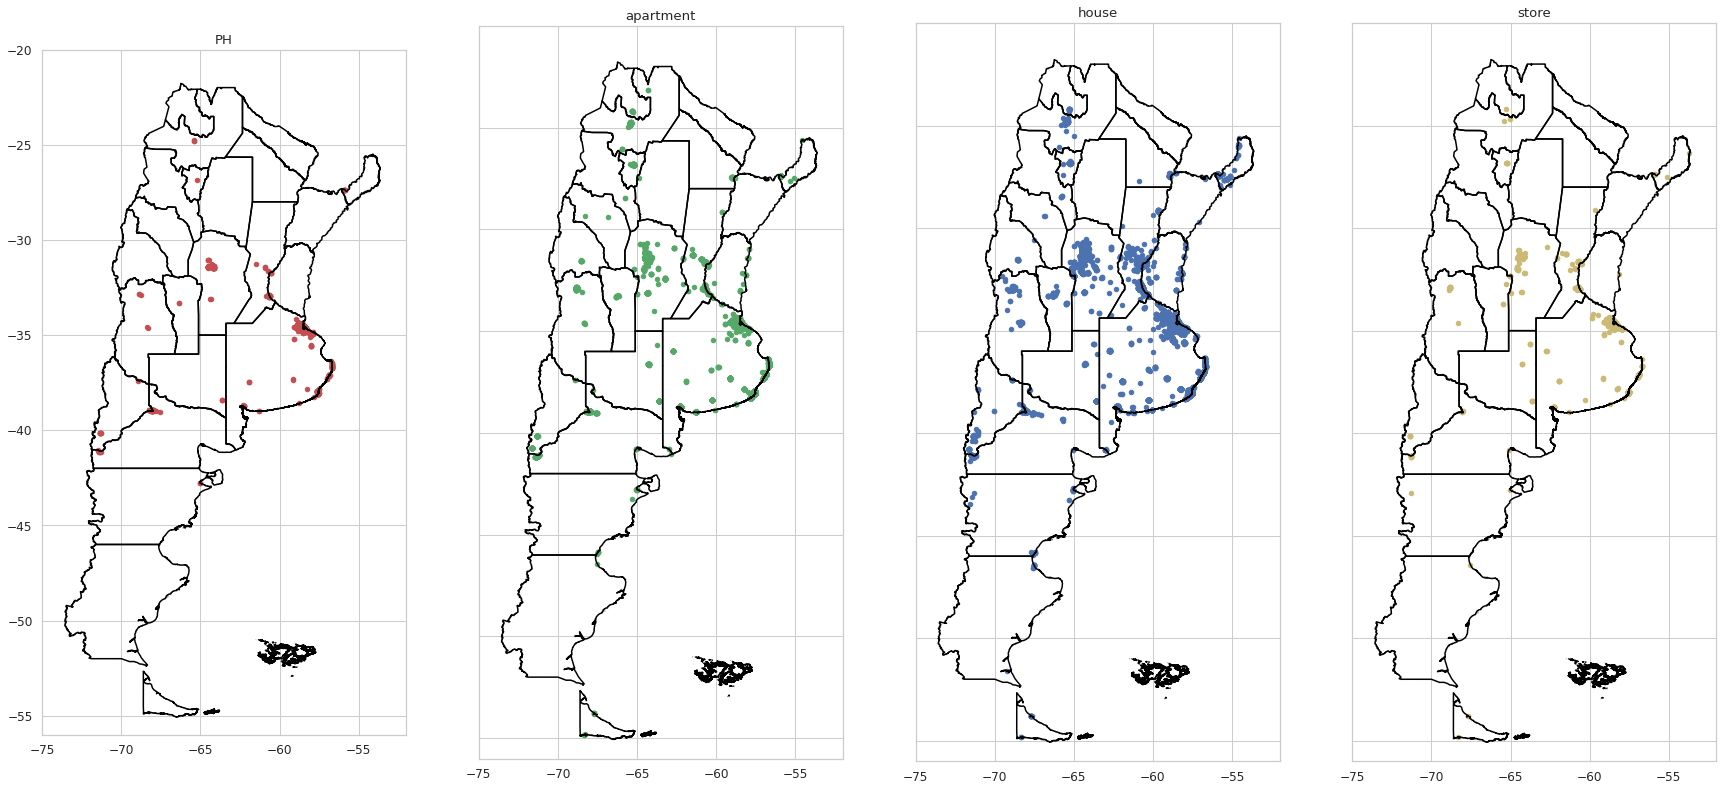

In [ ]:
fig, axes = plt.subplots(ncols = 4, sharex = True, sharey = True, figsize = (30,20))
colors = ['r', 'g', 'b', 'y']
props = list(data_geo.PROPERTY_TYPE.unique())

for ax, color, prop in zip(axes, colors, props):
  prov_geo.boundary.plot(ax = ax, edgecolor = 'black')
  data_geo[data_geo.PROPERTY_TYPE == prop].plot(ax = ax, color = color, markersize = 20.0)
  ax.set_xlim(-75,-52)
  ax.set_ylim(-56, -20)
  ax.set_title(prop)

Como es esperable, los 3 aglomerados urbanos más importantes cuentan con gran concentración de propiedades: AMBA, Gran Córdoba y Gran Rosario.
Se observa una distribución bastante pareja, teniendo en cuenta la representatividad de cada tipo de propiedad en el dataset. Corroboramos chequeando la proporción de NaN en geolocalización por tipo de propiedad

In [ ]:
pivot_prop = data.pivot_table(index = 'PROPERTY_TYPE', values = ['LAT-LON', 'TITLE'], aggfunc = 'count', dropna = False)
pivot_prop['Proporción de NaN en Geolocalización'] = (pivot_prop['LAT-LON'] / pivot_prop['TITLE'] * 100).map('{:.2f}%'.format)
pivot_prop.columns = ['Geoloc', 'Totales', 'Proporción de NaN en Geolocalización']
pivot_prop

Geoloc  Totales Proporción de NaN en Geolocalización
PROPERTY_TYPE                                                      
PH               3855     5751                               67.03%
apartment       41637    71065                               58.59%
house           21923    40267                               54.44%
store            2254     4136                               54.50%

PH tiene una proporción mas elevada de NaN, lo que explica por que en el mapa se ven menos en comparación a Tiendas, si bien hay mas PH que tiendas en el dataset.
Mas adelante intentaremos completar los datos de geolocalización para tener un dataset más completo.


---

Luego pasamos a graficar separando por provincia, buscando posibles outliers

Para esto primero unificaremos Provincia de Buenos Aires en el GeoDataFrame


In [ ]:
data_geo.STATE_NAME.unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Costa Atlántica', 'Entre Ríos',
       'Bs.As. G.B.A. Zona Norte', 'Santa Fe', 'Córdoba',
       'Bs.As. G.B.A. Zona Oeste', 'Misiones', 'Buenos Aires Interior',
       'Salta', 'Neuquén', 'Río Negro', 'San Luis', 'Mendoza',
       'Corrientes', 'Chubut', 'Tucumán', 'La Pampa', 'Chaco', 'San Juan',
       'Santa Cruz', 'Tierra Del Fuego', 'Catamarca',
       'Santiago Del Estero', 'Jujuy', 'La Rioja', 'Formosa'],
      dtype=object)

In [ ]:
data_geo['PROVINCIA'] = data_geo['STATE_NAME']
data_geo.loc[data_geo['STATE_NAME'].str.contains('Bs.As.|Buenos Aires', case=False, regex=True), 'PROVINCIA']='Buenos Aires'

data_geo.PROVINCIA.unique()

array(['Capital Federal', 'Buenos Aires', 'Entre Ríos', 'Santa Fe',
       'Córdoba', 'Misiones', 'Salta', 'Neuquén', 'Río Negro', 'San Luis',
       'Mendoza', 'Corrientes', 'Chubut', 'Tucumán', 'La Pampa', 'Chaco',
       'San Juan', 'Santa Cruz', 'Tierra Del Fuego', 'Catamarca',
       'Santiago Del Estero', 'Jujuy', 'La Rioja', 'Formosa'],
      dtype=object)

In [ ]:
prov_geo.loc[prov_geo.NAM == 'Ciudad Autónoma de Buenos Aires', 'NAM'] = 'Capital Federal'
prov_geo.loc[prov_geo.NAM == 'Tierra del Fuego, Antártida e Islas del Atlántico Sur', 'NAM'] = 'Tierra Del Fuego'
prov_geo.loc[prov_geo.NAM == 'Santiago del Estero', 'NAM'] = 'Santiago Del Estero'

In [ ]:
prov_geo.NAM.unique()

array(['Capital Federal', 'Neuquén', 'La Pampa', 'Mendoza', 'San Luis',
       'Córdoba', 'Santa Fe', 'Entre Ríos', 'San Juan', 'La Rioja',
       'Catamarca', 'Tucumán', 'Jujuy', 'Chaco', 'Formosa',
       'Santiago Del Estero', 'Tierra Del Fuego', 'Santa Cruz', 'Chubut',
       'Río Negro', 'Buenos Aires', 'Corrientes', 'Misiones', 'Salta'],
      dtype=object)

Y graficamos cada provincia por separado

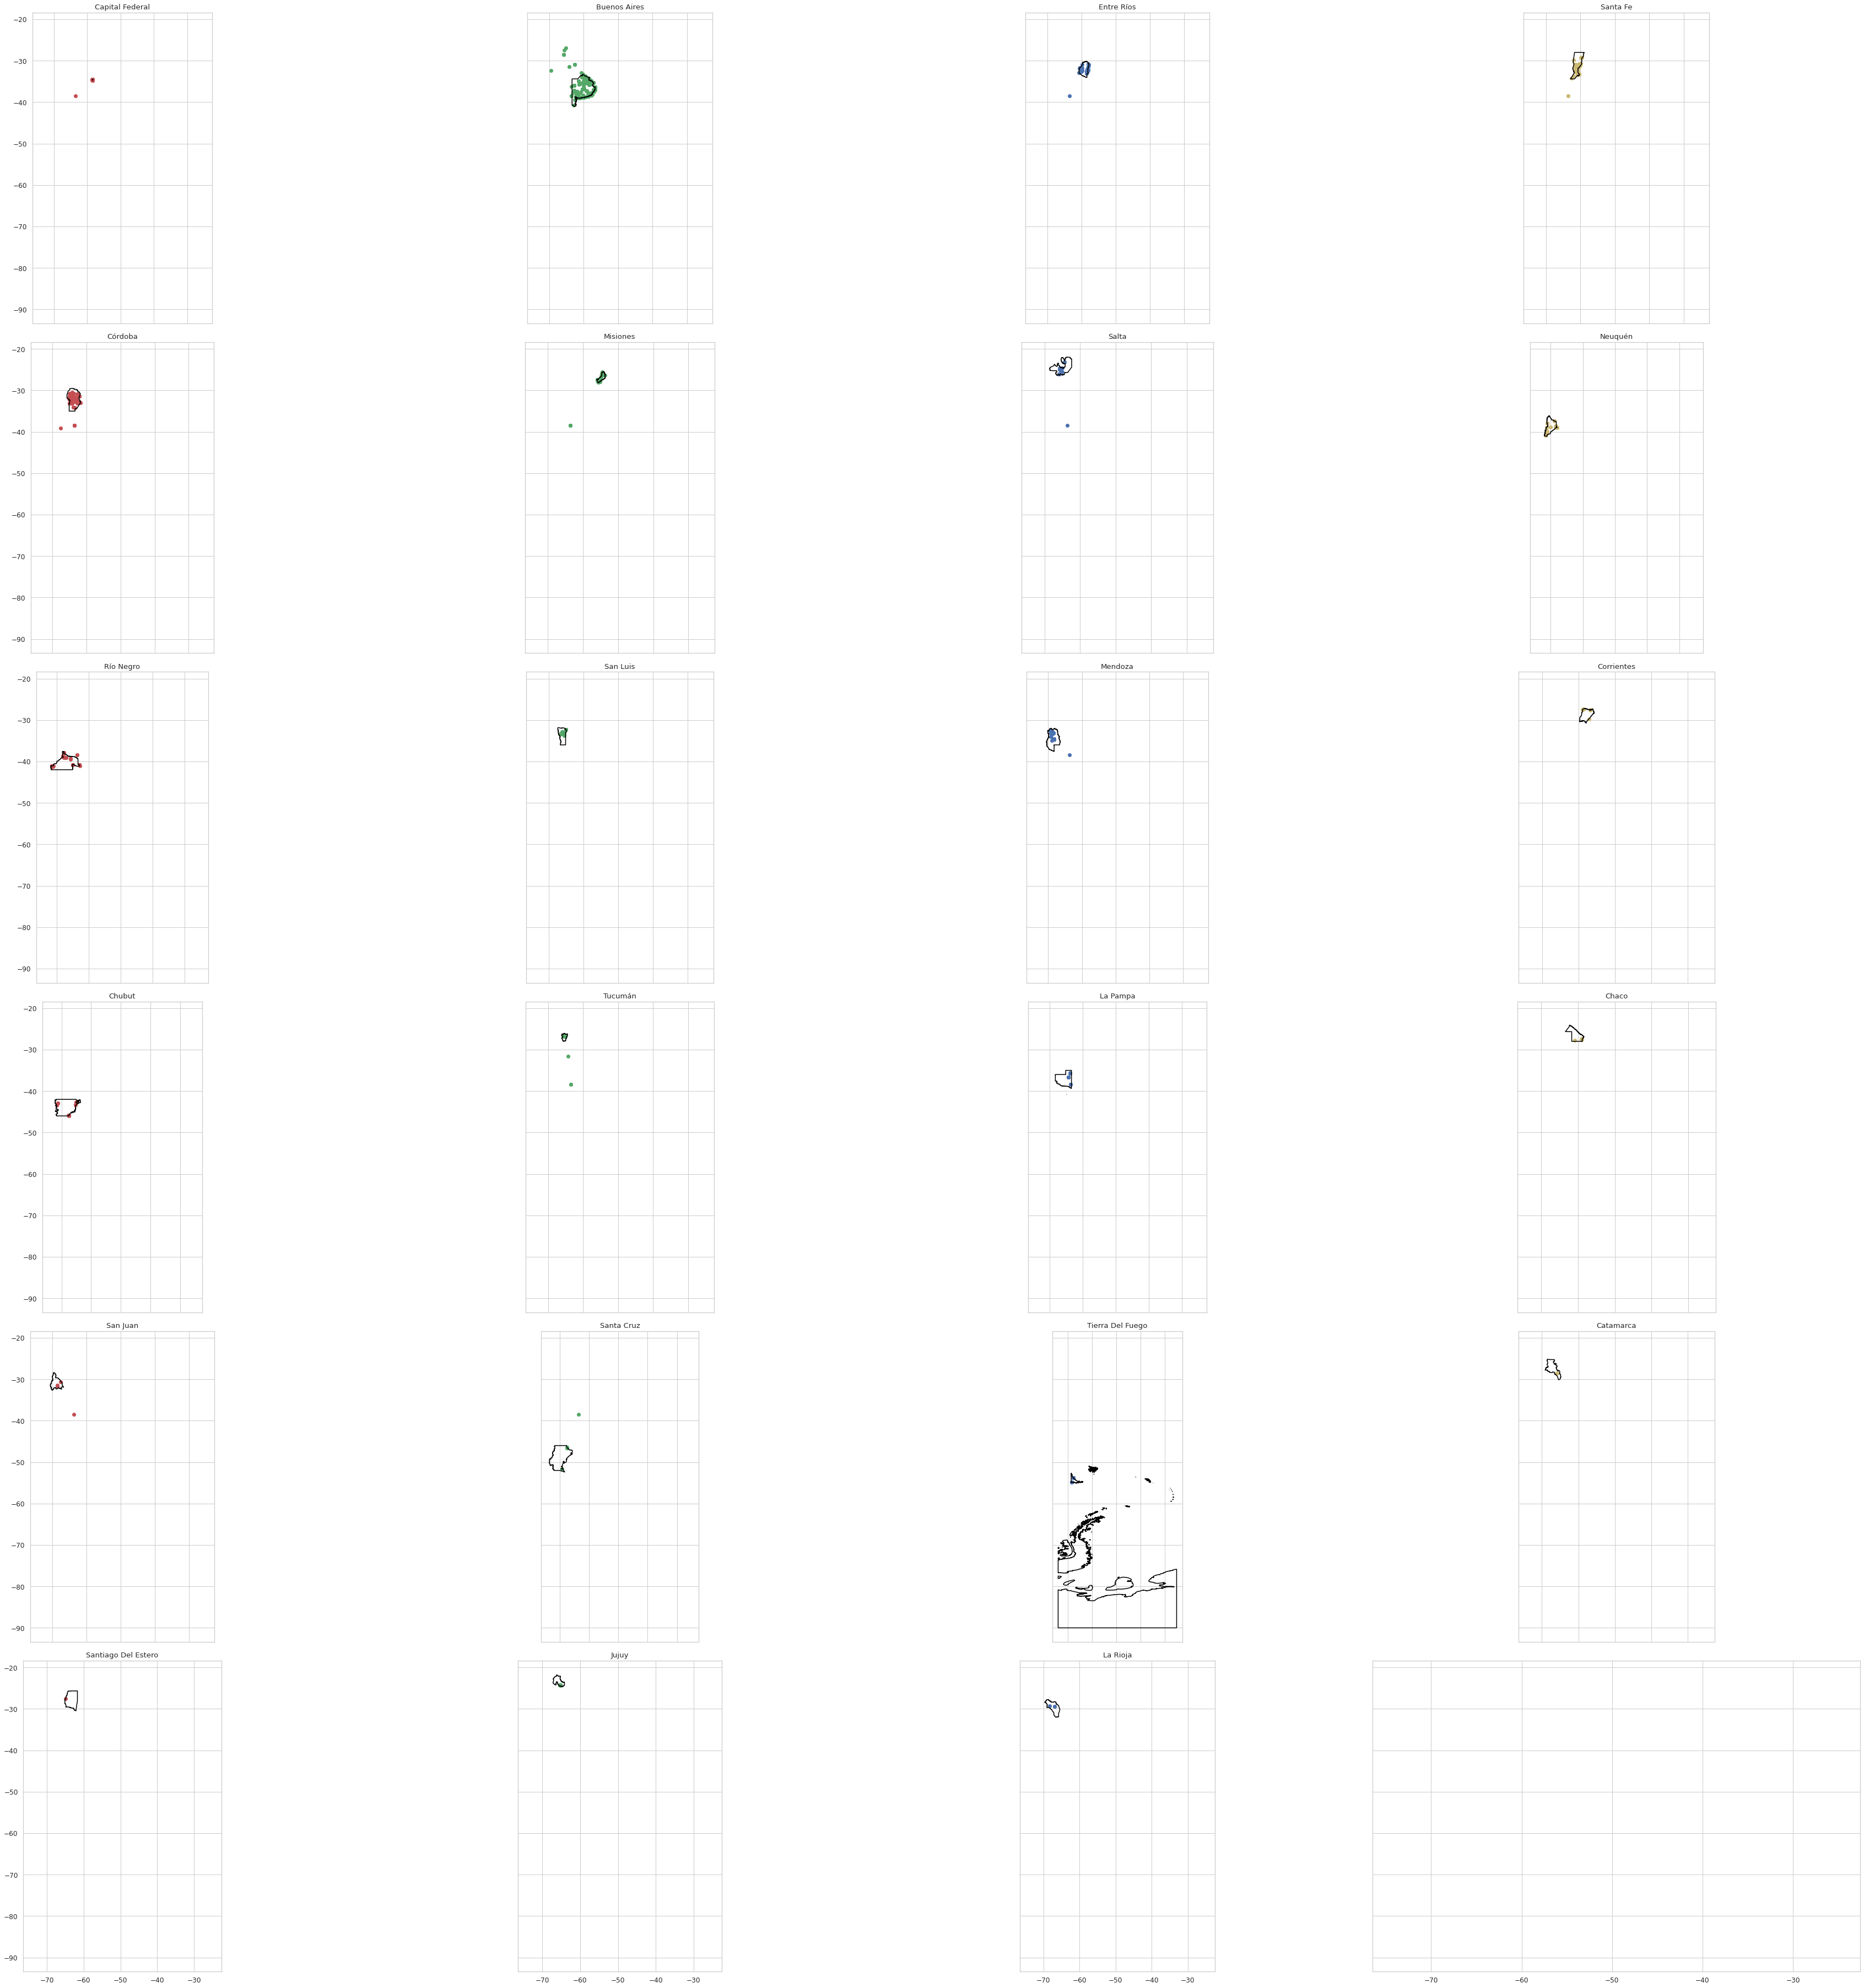

In [ ]:
fig, axes = plt.subplots(ncols = 4, nrows = 6, sharex = True, sharey = True, figsize = (50,50), constrained_layout = True)
colors = ['r', 'g', 'b', 'y'] * 6
provincias = list(data_geo.PROVINCIA.unique())

# Quitamos Formosa ya que todas sus propiedades aun no cuentan con geolocalización
provincias.remove('Formosa')
for ax, color, prov in zip(axes.flat, colors, provincias):
  prov_geo[prov_geo.NAM == prov].boundary.plot(ax = ax, edgecolor = 'black')
  data_geo[data_geo.PROVINCIA == prov].plot(ax = ax, color = color)
  ax.set_title(prov)

Se observan algunos outliers donde la geolocalización y la provincia no coinciden. Al ser pocos, procedemos a eliminarlos, ya que no se justifica el trabajo necesario para limpiarlos.

In [ ]:
provincias = data_geo.PROVINCIA.unique()
data_geo_ok = data_geo.copy()

for provincia in provincias:
  join_provincia = gpd.sjoin(data_geo[data_geo.PROVINCIA == provincia], prov_geo[prov_geo.NAM == provincia], how = 'left')
  drop_provincia = join_provincia[(join_provincia.index_right.isna()) & (join_provincia.LAT.notna())]
  data_geo_ok = data_geo_ok.drop(drop_provincia.index)
  data = data.drop(drop_provincia.index)

In [ ]:
print(f'Luego de la limpieza se eliminaron {data_geo.shape[0] - data_geo_ok.shape[0]} datos')

Luego de la limpieza se eliminaron 195 datos


Volvemos a graficar, chequeando la limpieza de outliers

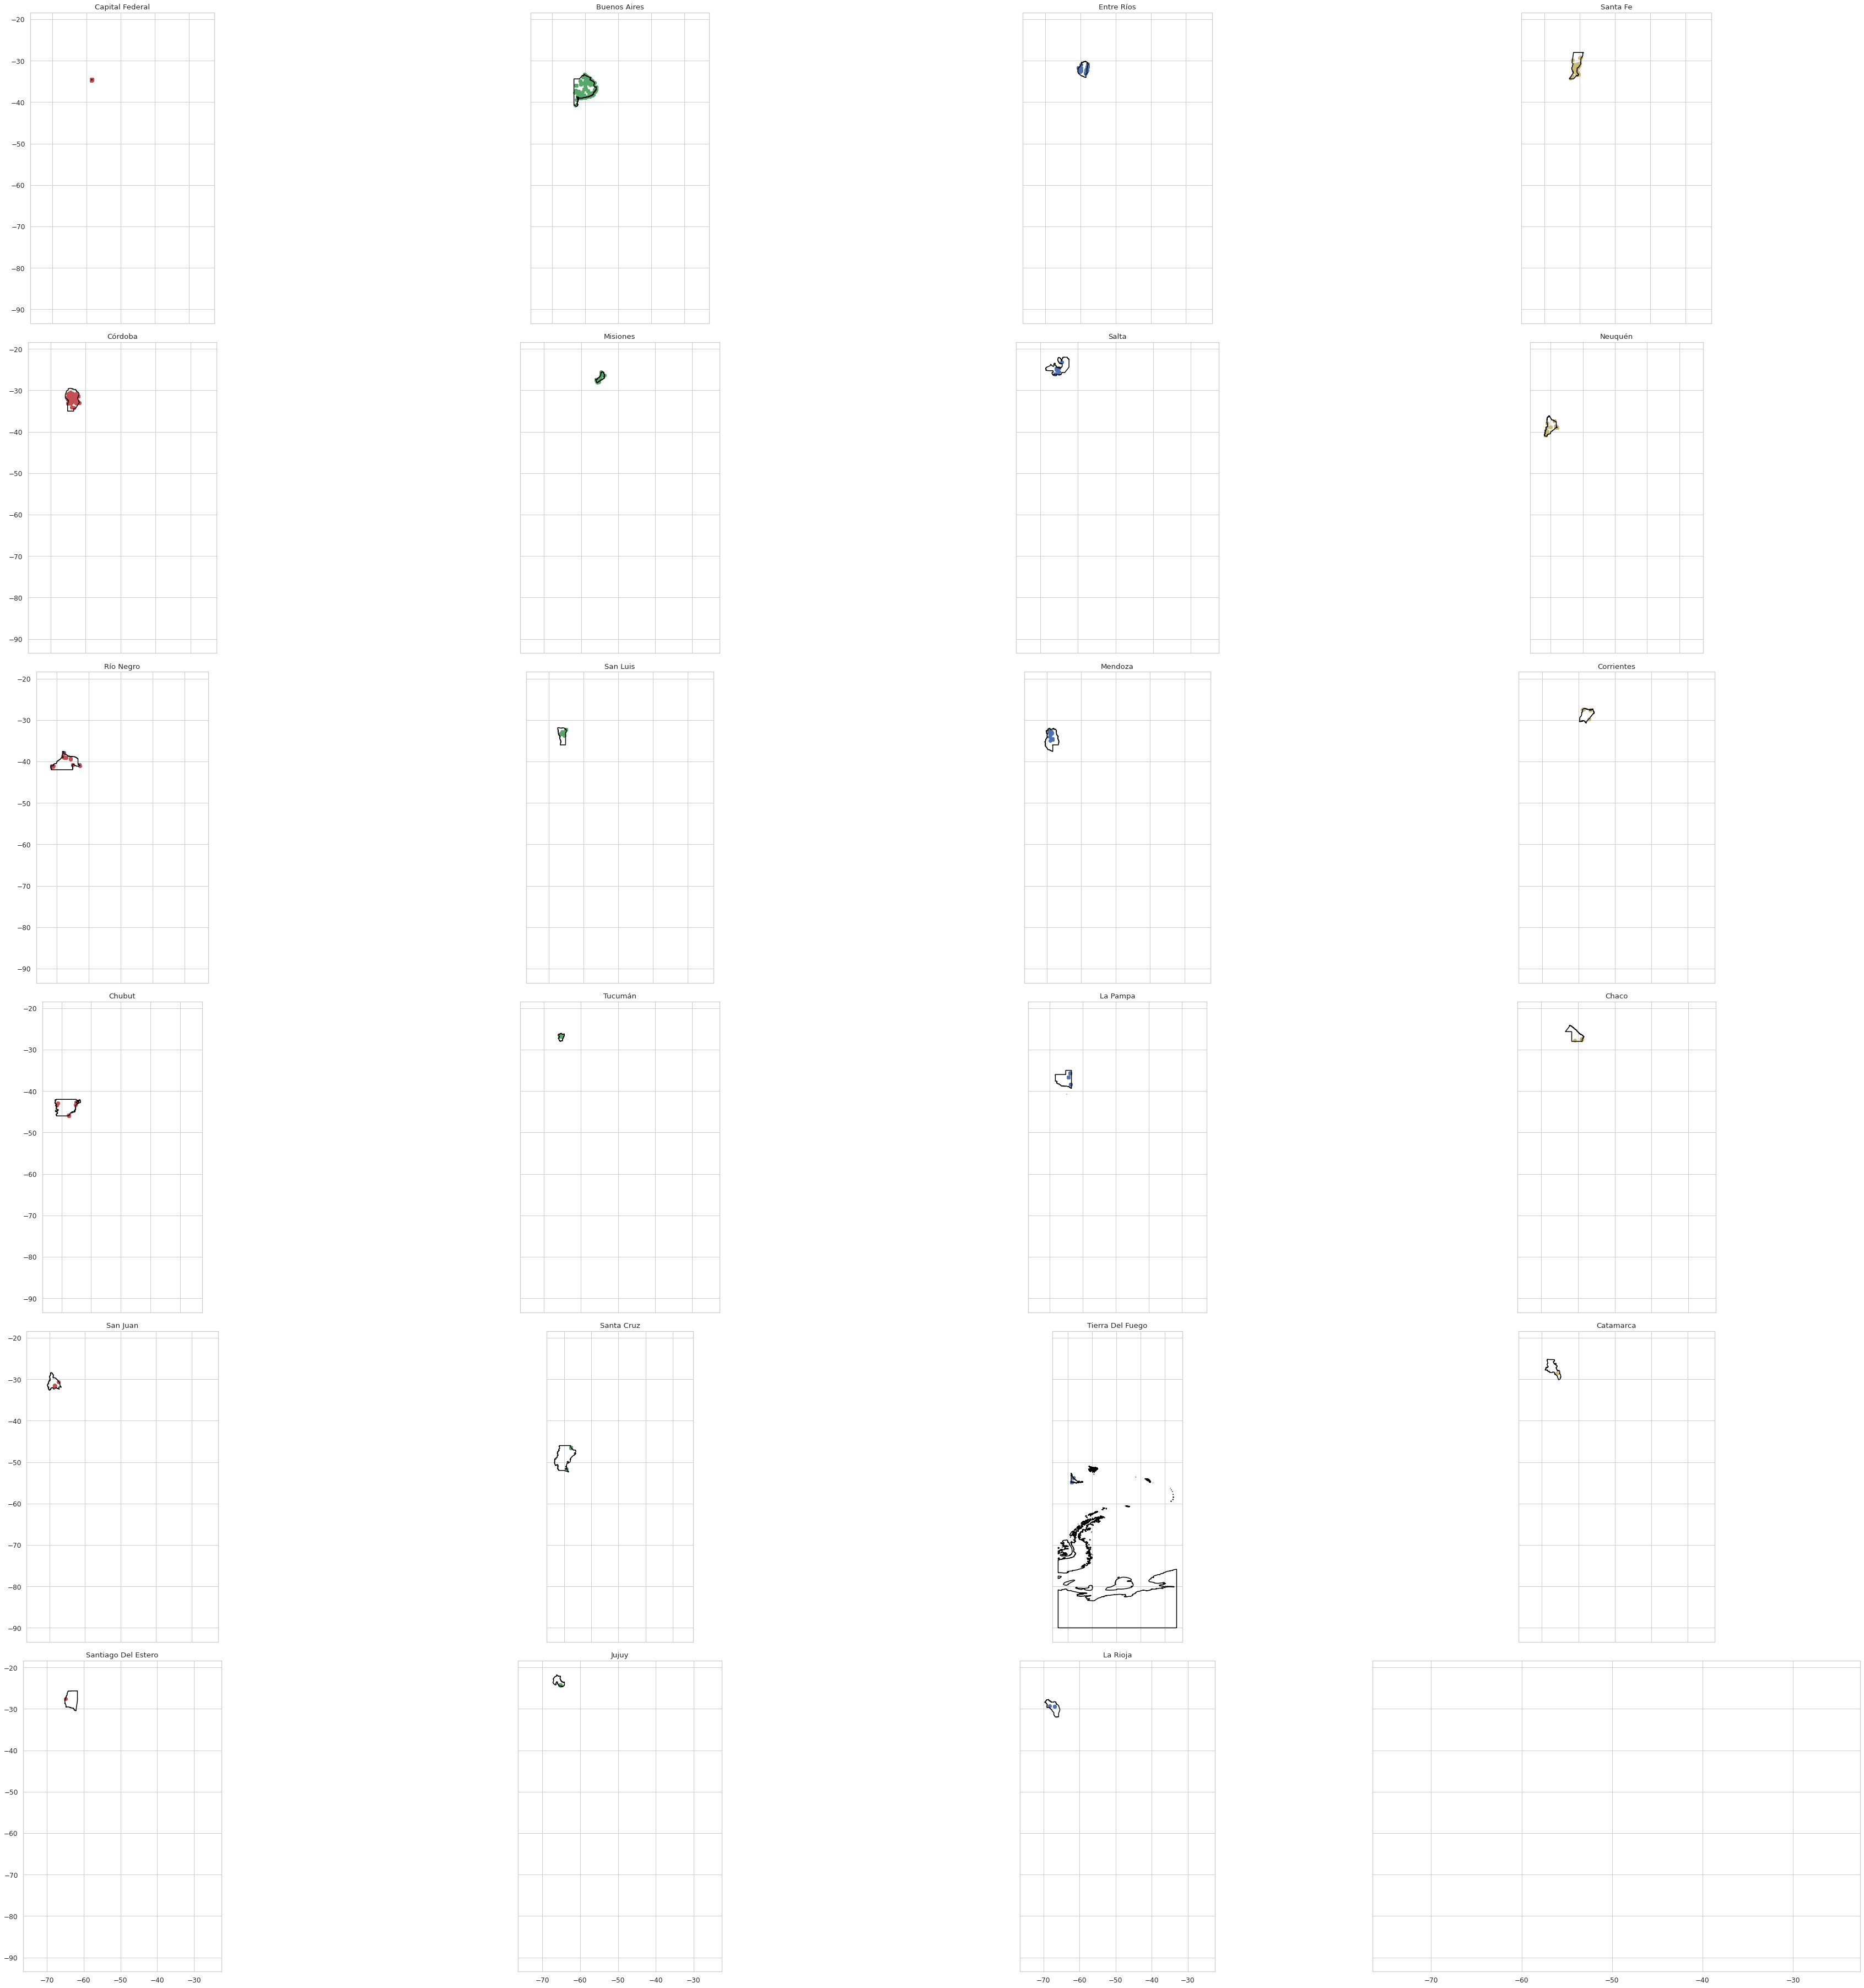

In [ ]:
fig, axes = plt.subplots(ncols = 4, nrows = 6, sharex = True, sharey = True, figsize = (50,50), constrained_layout = True)
colors = ['r', 'g', 'b', 'y'] * 6
provincias = list(data_geo_ok.PROVINCIA.unique())
# Quitamos Formosa ya que todas sus propiedades aun no cuentan con geolocalización
provincias.remove('Formosa')

for ax, color, prov in zip(axes.flat, colors, provincias):
  prov_geo[prov_geo.NAM == prov].boundary.plot(ax = ax, edgecolor = 'black')
  data_geo_ok[data_geo_ok.PROVINCIA == prov].plot(ax = ax, color = color)
  ax.set_title(prov)

plt.show()

## **Graficamos las distribuciones de variables numéricas (no geográficas)**

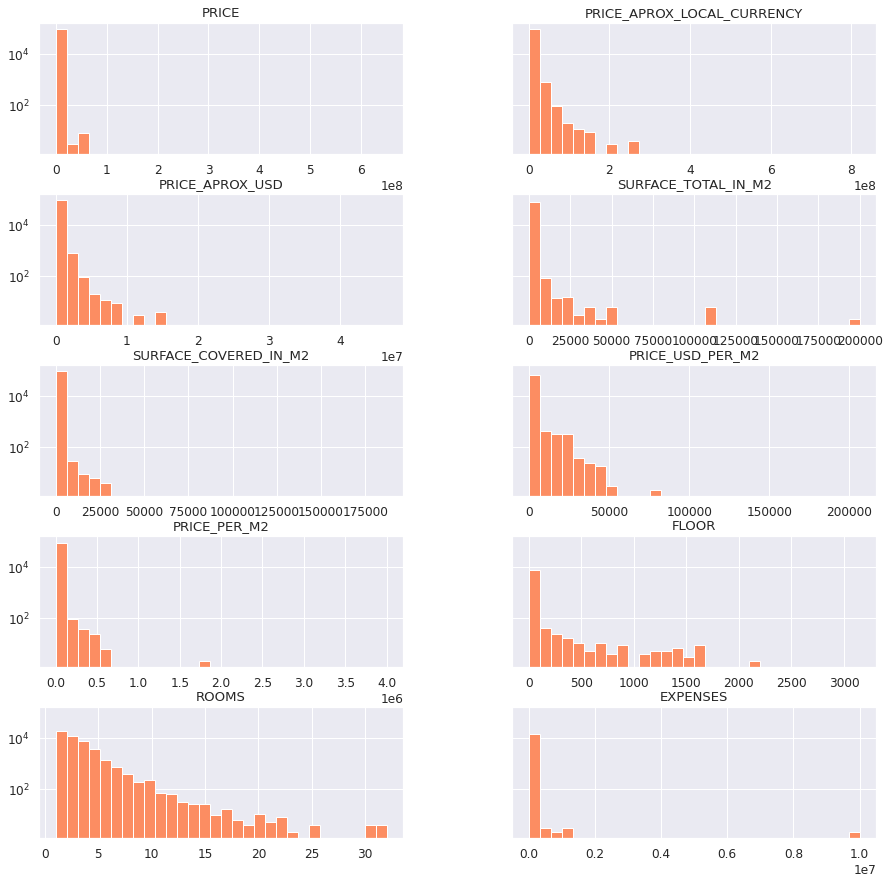

In [ ]:
sns.set(style = 'darkgrid', palette = 'Set2', font_scale = 1.1)
numericas = data.select_dtypes(include = 'number').columns.drop(['GEONAMES_ID', 'LAT', 'LON'])
data.hist(column = numericas, bins = 30, figsize = (15,15), layout = (5,2), sharey = True, log = True, color = sns.color_palette('Set2')[1])
plt.show()


In [ ]:
for col in numericas:
  print(f'La variable {col} presenta una asimetría de {data[col].skew()}')

La variable PRICE presenta una asimetría de 237.2729207339539
La variable PRICE_APROX_LOCAL_CURRENCY presenta una asimetría de 29.646146855405874
La variable PRICE_APROX_USD presenta una asimetría de 29.64614685825727
La variable SURFACE_TOTAL_IN_M2 presenta una asimetría de 70.54673417641236
La variable SURFACE_COVERED_IN_M2 presenta una asimetría de 180.05149203496794
La variable PRICE_USD_PER_M2 presenta una asimetría de 16.60392740500492
La variable PRICE_PER_M2 presenta una asimetría de 63.19013259440206
La variable FLOOR presenta una asimetría de 12.435430878261954
La variable ROOMS presenta una asimetría de 2.9863670271861906
La variable EXPENSES presenta una asimetría de 80.44611274614373


Comprobamos que las variables numéricas del dataset presentan en su gran mayoría una marcada asimetría positiva.
También llaman la atención algunos valores Outliers en Expensas y Precio por m2 que sera importante observar.

In [ ]:
# Seteamos el formato de floats para mirar mejor la información
pd.options.display.float_format = '{:.2f}'.format
data.describe().drop(['GEONAMES_ID', 'LAT', 'LON'], axis = 1)

PRICE  PRICE_APROX_LOCAL_CURRENCY  PRICE_APROX_USD  \
count    100635.00                   100635.00        100635.00   
mean     468784.94                  4231035.81        239793.47   
std     2261983.89                  6908579.21        391542.93   
min        5000.00                    87383.50          4952.45   
25%      110000.00                  1583309.44         89733.88   
50%      185000.00                  2558452.50        145000.00   
75%      420000.00                  4675792.50        265000.00   
max   650000000.00                821271104.30      46545445.00   

       SURFACE_TOTAL_IN_M2  SURFACE_COVERED_IN_M2  PRICE_USD_PER_M2  \
count             81755.00              101172.00          68489.00   
mean                232.37                 133.07           2160.98   
std                1741.84                 724.84           2758.74   
min                   0.00                   0.00              0.60   
25%                  50.00                  45.00           1219.82   
50%                  84.00                  75.00           1802.47   
75%                 200.00                 150.00           2488.17   
max              200000.00              187000.00         206333.33   

       PRICE_PER_M2   FLOOR    ROOMS    EXPENSES  
count      87526.00 7892.00 47295.00    14249.00  
mean        6917.52   17.47     3.08     5010.89  
std        28399.18  120.30     1.86   120495.16  
min            1.51    1.00     1.00        1.00  
25%         1550.00    1.00     2.00     1000.00  
50%         2214.29    3.00     3.00     2000.00  
75%         3356.64    6.00     4.00     4000.00  
max      3999999.96 3150.00    32.00 10001500.00

In [ ]:
# Volvemos al formato por defecto
pd.reset_option('display.float_format')

##**VALORES NULOS**


**Calculamos el porcentaje de nulos para cada columna**

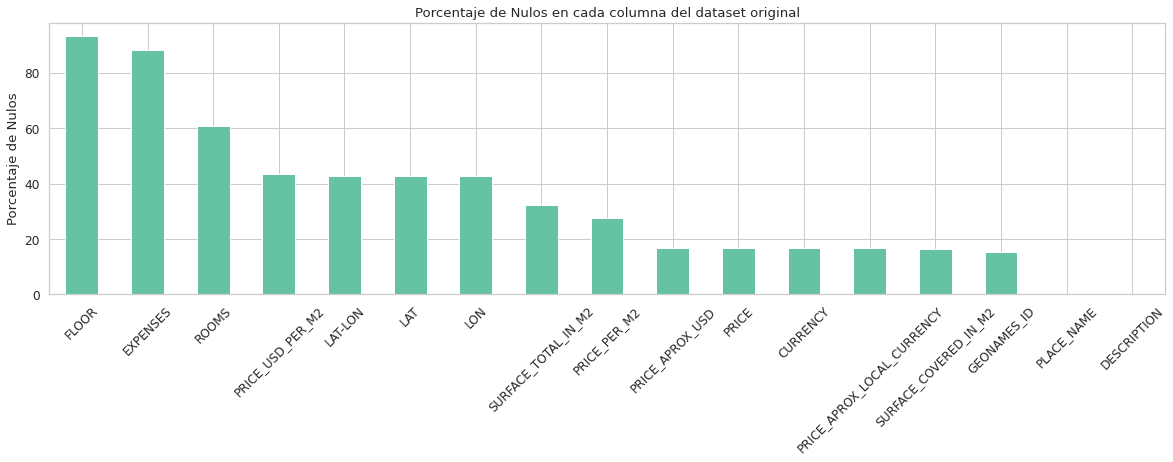

In [ ]:
info_nulos = pd.DataFrame({'nulos': data.isna().sum(), 'porcentaje' : (data.isna().sum()) / data.isna().count() * 100})

# Dejamos las columnas con 0 nulls afuera
info_nulos = info_nulos[info_nulos.porcentaje != 0]

info_nulos = info_nulos.sort_values(by = 'porcentaje', ascending = False)

sns.set_style('whitegrid')

info_nulos.porcentaje.plot(kind = 'bar', figsize = (20, 5), rot = 45, title="Porcentaje de Nulos en cada columna del dataset original", ylabel="Porcentaje de Nulos")

plt.show()

Se observa un elevado peso de valores nulos, particularmente en las variables que describen ciertas características específicas (cantidad de pisos/cuartos, expensas), en las variables de geolocalización, en las variables de superficie y (lo que es un poco más alarmante), **en la variable target de Precio por M2 en USD** y otras variables de precio.

Pero contamos con mucha información en las variables de título y descripción, por lo que un trabajo en profundidad de **extracción de información con REGEX** será crucial para completar el dataset.

En el caso de geolocalización, vemos la columna de `GEONAMES_ID` mas completa que `LAT` y `LON`, por lo que podremos hacer un cruce de información ahi. También el desagregado de `PLACE_WITH_PARENT_NAMES` nos puede aportar a la hora de imputar esos datos, al estar completas.

## **LIMPIEZA DE DATOS**

--------------------------------------------------------------------------------

**PLACE_NAME Y PLACE_WITH_PARENT_NAMES**

Se observa que `PLACE NAME` menciona a veces la localidad, o a veces la ciudad. La columna `PLACE_WITH_PARENT_NAMES` presenta una información más completa con varios niveles de profundidad. Por ejemplo:

In [ ]:
data.iloc[4:5]

PROPERTY_TYPE PLACE_NAME                            PLACE_WITH_PARENT_NAMES  \
4     apartment     Centro  |Argentina|Buenos Aires Costa Atlántica|Mar de...   

                     STATE_NAME  GEONAMES_ID                  LAT-LON  \
4  Buenos Aires Costa Atlántica    3435548.0  -38.0026256,-57.5494468   

         LAT        LON    PRICE CURRENCY  PRICE_APROX_LOCAL_CURRENCY  \
4 -38.002626 -57.549447  64000.0      USD                   1129248.0   

   PRICE_APROX_USD  SURFACE_TOTAL_IN_M2  SURFACE_COVERED_IN_M2  \
4          64000.0                 35.0                   35.0   

   PRICE_USD_PER_M2  PRICE_PER_M2  FLOOR  ROOMS  EXPENSES  \
4       1828.571429   1828.571429    NaN    NaN       NaN   

                                       PROPERATI_URL  \
4  http://www.properati.com.ar/15bok_venta_depart...   

                                         DESCRIPTION  \
4  departamento con fantástica iluminación natura...   

                                               TITLE  \
4  depto 2 amb al contrafrente zona centro/plaza ...   

                      geometry  
4  POINT (-57.54945 -38.00263)

Aquí se trata de una propiedad en Mar del Plata, sin embargo si contamos solamente con la información de `PLACE_NAME` y `STATE_NAME` perdemos la información de localidad.
Por lo tanto procederemos a hacer un split de la columna `PLACE_WITH_PARENT_NAMES` para obtener la información más detallada. Por otra parte como observamos anteriormente, se trata de una columna sin nulos, a diferencia de `PLACE_NAME`

###**`PLACE_WITH_PARENT_NAMES`: split**###
Aprovecharemos la informacion contenida dentro de la columna, separando los datos por el delimiter "|", para crear las siguientes columnas:



1.   `BLANK`
2.   `PAIS`
2.   `PROVINCIA`
2.   `CIUDAD`
2.   `BARRIO`
2.   `BARRIO_2`
2.   `BLANK_2`



In [ ]:
# data['place_name'].fillna(data['place_with_parent_names'].str.split('|').str[3], inplace=True)
data[["BLANK","PAIS","PROVINCIA","CIUDAD","BARRIO","BARRIO_2","BLANK_2"]]= data.PLACE_WITH_PARENT_NAMES.str.split("|", expand = True)


Ya utilizada la columna `PLACE_WITH_PARENT_NAMES` procederemos a eliminarla, asi como tamien eliminaremos las siguientes columnas:
``

1.   `BLANK`
2.   `PAIS`
2.   `PLACE_WITH_PARENT_NAMES`
2.   `BLANK_2`


Revisaremos los valores que contiene cada una de ellas a fines de justificar su eliminacion.



In [ ]:
drop_split_blank = pd.DataFrame({"BLANK":data.BLANK.value_counts()})
drop_split_pais = pd.DataFrame({"PAIS":data.PAIS.value_counts()})

display(drop_split_blank)
display(drop_split_pais)


BLANK
  121024

PAIS
Argentina  121024


**BLANK:** poseemos 121.220 valores vacios.

**ARGENTINA**: poseemos 121.220 "Argentina"

Como ambos Count coinciden con la cantidad de filas que posee nuestro dataset determinamos dropearlas.

In [ ]:
data = data.drop("PAIS", axis = 1 )
data = data.drop("BLANK", axis = 1 )
data = data.drop("PLACE_WITH_PARENT_NAMES", axis = 1 )

In [ ]:
count_blank_2 = data.BLANK_2.value_counts() + data.BLANK_2.isnull().sum()
display(count_blank_2)

    121024
Name: BLANK_2, dtype: int64

La columna esta compuesta por Nulls + valores cuyo valor es "". Por lo tanto la eliminaremos

In [ ]:
data = data.drop("BLANK_2", axis = 1 )


Procederemos a comparar la valores contenidos en las nuevas columnas

2.   `PROVINCIA`
2.   `CIUDAD`
2.   `BARRIO`
2.   `BARRIO_2`


#### `STATE_NAME` VS `PROVINCIA`
Sabiendo que en el DataSet de origen contiene la columna `STATE_NAME` 

lo que haremos es compararla contra la columna agregada de  `PROVINCIA`

In [ ]:
chequeo_state_provincia = data.STATE_NAME == data.PROVINCIA
display(chequeo_state_provincia.value_counts())


True    121024
dtype: int64

Como podemos ver no existen diferencias entre columnas con lo cual  procederemos a eliminar la columna agregada de `PROVINCIA` (debido a que ambas contienen la misma informacion en cada una de las filas)

Filas del dataset = 121.220

Cantenidad de True obtenidos = 121.220

In [ ]:
data = data.drop("PROVINCIA", axis = 1 )

####`PLACE_NAME` VS `CIUDAD`/`BARRIO`/`BARRIO_2`
Siguiendo la misma logica de `STATE_NAME` VS `PROVINCIA`, analizaremos `PLACE_NAME` para ubicar con cual de las 3 columnas (`CIUDAD`, `BARRIO`, `BARRIO_2`) para detectar aquellas que no coinciden con ninguna.

In [ ]:
columna_filtro = ["STATE_NAME", "PLACE_NAME", "CIUDAD","BARRIO","BARRIO_2","TITLE", "PRICE_APROX_USD"]


Aquí, si se cumple la primera condición de la lista de condiciones para una fila, el valor de la columna `CHEQUEO_PLACE` para esa fila específica se establece en el primer elemento de la variable choicelist. Otras condiciones en la lista de condiciones son similares. Si no se cumple ninguna de las condiciones en la lista de condiciones, el valor de la columna `CHEQUEO_PLACE` para esa fila se establece en el valor del parámetro default en el método np.where() , en este caso "FALSE"

In [ ]:
conditionlist = [
    (data["PLACE_NAME"] ==data["CIUDAD"]),
    (data["PLACE_NAME"] ==data["BARRIO"]),
    (data["PLACE_NAME"] ==data["BARRIO_2"])]

choicelist = [True, True, True]

data['CHEQUEO_PLACE'] = np.select(conditionlist, choicelist, default=False)

Haremos lo mismo que en el codigo anterior, pero esta vez la columna que agregaremos sea para ubicar con cual de las 3 ubicaciones coincide (Ciudad, Barrio, o Barrio_2)

In [ ]:
conditionlist = [
    (data["PLACE_NAME"] ==data["CIUDAD"]),
    (data["PLACE_NAME"] ==data["BARRIO"]),
    (data["PLACE_NAME"] ==data["BARRIO_2"])]

choicelist = ["CIUDAD", "BARRIO", "BARRIO_2"]

data['CHEQUEO_UBICACION'] = np.select(conditionlist, choicelist, default="NO COINCIDE")


Analicemos como quedo nuestro DF:

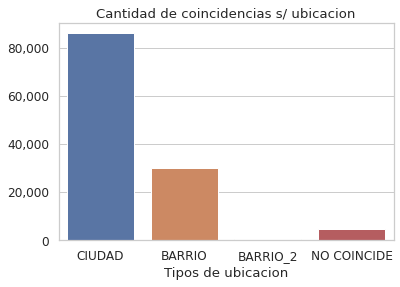

In [ ]:
sns.set(style = 'whitegrid', palette = 'deep', font_scale = 1.1)
ax = sns.countplot(x = data.CHEQUEO_UBICACION)

ax.set_title('Cantidad de coincidencias s/ ubicacion')
ax.set_xlabel('Tipos de ubicacion')
ax.set_ylabel('')
current_values = plt.gca().get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()


Analizemos los valores que se encuentran en "NO COINCIDE"

In [ ]:
display(data.loc[(data['CHEQUEO_PLACE'] == False),].PLACE_NAME.value_counts())
display(data.loc[(data['CHEQUEO_PLACE'] == False),].PLACE_NAME.isnull().sum())

Córdoba                         2643
Capital Federal                 1297
Bs.As. G.B.A. Zona Norte         222
Mendoza                          130
Tucumán                           75
Bs.As. G.B.A. Zona Oeste          65
Misiones                          43
Santa Fe                          33
Buenos Aires Interior             30
Buenos Aires Costa Atlántica      26
San Luis                          24
Salta                             21
Chubut                            17
Bs.As. G.B.A. Zona Sur            16
Neuquén                           10
Río Negro                          7
San Juan                           7
Tierra Del Fuego                   6
Catamarca                          3
La Pampa                           3
Santiago Del Estero                3
Corrientes                         2
La Rioja                           1
Jujuy                              1
Chaco                              1
Name: PLACE_NAME, dtype: int64

23

Veamos que son esos 23 Nulls en la columna `PLACE_NAME`

In [ ]:
display(data.loc[(data['PLACE_NAME'].isnull() == True),columna_filtro])
prueba = (data.loc[(data['PLACE_NAME'].isnull() == True),columna_filtro])

STATE_NAME PLACE_NAME CIUDAD BARRIO BARRIO_2  \
6489   Bs.As. G.B.A. Zona Norte       None  Tigre                   
10201  Bs.As. G.B.A. Zona Norte       None  Tigre                   
11451  Bs.As. G.B.A. Zona Norte       None  Tigre                   
14839  Bs.As. G.B.A. Zona Norte       None  Tigre                   
18622  Bs.As. G.B.A. Zona Norte       None  Tigre                   
21922  Bs.As. G.B.A. Zona Norte       None  Tigre                   
23664  Bs.As. G.B.A. Zona Norte       None  Tigre                   
24722  Bs.As. G.B.A. Zona Norte       None  Tigre                   
38856  Bs.As. G.B.A. Zona Norte       None  Tigre                   
45970  Bs.As. G.B.A. Zona Norte       None  Tigre                   
46642  Bs.As. G.B.A. Zona Norte       None  Tigre                   
53130  Bs.As. G.B.A. Zona Norte       None  Tigre                   
55306  Bs.As. G.B.A. Zona Norte       None  Tigre                   
57703  Bs.As. G.B.A. Zona Norte       None  Tigre                   
57759  Bs.As. G.B.A. Zona Norte       None  Tigre                   
57764  Bs.As. G.B.A. Zona Norte       None  Tigre                   
57793  Bs.As. G.B.A. Zona Norte       None  Tigre                   
58004  Bs.As. G.B.A. Zona Norte       None  Tigre                   
58037  Bs.As. G.B.A. Zona Norte       None  Tigre                   
59069  Bs.As. G.B.A. Zona Norte       None  Tigre                   
62411  Bs.As. G.B.A. Zona Norte       None  Tigre                   
62413  Bs.As. G.B.A. Zona Norte       None  Tigre                   
63849  Bs.As. G.B.A. Zona Norte       None  Tigre                   

                                                   TITLE  PRICE_APROX_USD  
6489               venta de casa en santa maría de tigre         650000.0  
10201  venta casa santa maría de tigre country barrio...         535000.0  
11451                     santa maria de tigre impecable         550000.0  
14839              venta de casa en santa maría de tigre         480000.0  
18622  casa con increible vista al lago con playa y m...        1297000.0  
21922           venta casa - barrio santa maria de tigre         440000.0  
23664    casa en venta en santa maria de tigre con renta         480000.0  
24722              venta de casa en santa maría de tigre         530000.0  
38856                       casa (barrio cerrado), venta        1350000.0  
45970  excelente monoambiente. barrio el palmar.  con...          95000.0  
46642                               venta de casa al rio        1470000.0  
53130                                      casa en venta         630000.0  
55306             santa maría de tigre. casa con amarra.         470000.0  
57703                           santa maria de tigre 100         650000.0  
57759                           santa maria de tigre 100         580000.0  
57764                           santa maria de tigre 100         970000.0  
57793                           santa maria de tigre 100         760000.0  
58004                           santa maria de tigre 100         550000.0  
58037                           santa maria de tigre 100         590000.0  
59069      casa en venta al agua en santa maria de tigre         640000.0  
62411       venta casa a estrenar en las tipas nordelta          340000.0  
62413             muy linda casa a estrenar en las tipas         419000.0  
63849                    oportunidad! casa en la alameda         400000.0

Reemplazaremos esos None por Tigre

In [ ]:
data.loc[data["PLACE_NAME"].isnull() == True,"PLACE_NAME"] = "Tigre"
display(data.loc[(data['CHEQUEO_PLACE'] == False),].PLACE_NAME.isnull().sum())

0

Aquellos records que no matchean con ninguna ubicacion, veamos si lo que contiene `PLACE_NAME` coincide con `STATE_NAME`.

De ser asi no podremos usar la columna para seguir complentando nuestros records, si no que deberemos buscar otras alternativas para seguir completandolos.

In [ ]:
count_state= data.loc[(data['CHEQUEO_PLACE'] == False),columna_filtro].STATE_NAME.value_counts()
count_place = data.loc[(data['CHEQUEO_PLACE'] == False),columna_filtro].PLACE_NAME.value_counts()
comparacion = pd.DataFrame({"STATE_NAME":count_state,"PLACE_NAME":count_place,"DIFERENCIA": count_state - count_place})
comparacion               

STATE_NAME  PLACE_NAME  DIFERENCIA
Bs.As. G.B.A. Zona Norte           245.0         222        23.0
Bs.As. G.B.A. Zona Oeste            65.0          65         0.0
Bs.As. G.B.A. Zona Sur              16.0          16         0.0
Buenos Aires Costa Atlántica        26.0          26         0.0
Buenos Aires Interior               30.0          30         0.0
Capital Federal                   1297.0        1297         0.0
Catamarca                            3.0           3         0.0
Chaco                                1.0           1         0.0
Chubut                              17.0          17         0.0
Corrientes                           2.0           2         0.0
Córdoba                           2643.0        2643         0.0
Jujuy                                1.0           1         0.0
La Pampa                             3.0           3         0.0
La Rioja                             1.0           1         0.0
Mendoza                            130.0         130         0.0
Misiones                            43.0          43         0.0
Neuquén                             10.0          10         0.0
Río Negro                            7.0           7         0.0
Salta                               21.0          21         0.0
San Juan                             7.0           7         0.0
San Luis                            24.0          24         0.0
Santa Fe                            33.0          33         0.0
Santiago Del Estero                  3.0           3         0.0
Tierra Del Fuego                     6.0           6         0.0
Tigre                                NaN          23         NaN
Tucumán                             75.0          75         0.0

COmo podemos ver, aquellos records que no Matchean con ningun de la ubicaciones, es porque en la columna `PLACE_NAME` contienen informacion sobre la Provinica (coinciden con la columna `STATE_NAME`

Pasemos a ver como quedaron las columnas relacionadas con el split:

In [ ]:
data.loc[(data['CHEQUEO_PLACE'] == False),columna_filtro].sample(20)
display(data.loc[(data['CHEQUEO_PLACE'] == False),columna_filtro].isna().sum())

STATE_NAME            0
PLACE_NAME            0
CIUDAD                0
BARRIO             4686
BARRIO_2           4686
TITLE                 0
PRICE_APROX_USD    1056
dtype: int64

In [ ]:
display(data.loc[(data['BARRIO'].isna() == True),columna_filtro].TITLE.value_counts().head(20))

departamento - nueva cordoba           1001
departamento en p.chacabuco             237
departamento en nueva cordoba            87
departamento - capital                   70
casa en venta                            67
departamento - cordoba capital           49
departamento - capital federal           38
departamento - microcentro               35
departamento en cordoba capital          30
casa - capital                           30
casa - cordoba capital                   24
departamento venta                       24
local en p.chacabuco                     20
departamento - la estanzuela             18
casa - p.chacabuco                       17
departamento en venta                    17
departamento - centro                    15
casa - claros del bosque                 15
departamento - manatiales                14
titulo para publicacion en portales      12
Name: TITLE, dtype: int64

Podriamos llegar a completar aquellos datos faltantes en Barrio analizando la columna `TITLE` utilizando Regex pero solo para recuperar completar datos en `BARRIO`, ya que son solamente 5k de records. No es el caso de `BARRIO_2` donde nos encontramos con un total de 80.779 valores incompletos.

In [ ]:
display(data.BARRIO_2.isna().sum())
data = data.drop("BARRIO_2", axis = 1 )

80608

## *Guardamos 1er paso intermedio: dataset ordenado, sin imputación*

In [ ]:
data = data.drop('geometry', axis = 1)

In [ ]:
if crear_parquet:
    data.to_parquet(f'{ubicacion_dataset}properati_paso1.parquet')
else:
  data.to_csv(f'{ubicacion_dataset}properati_paso1.csv')

Para comenzar a correr la notebook desde aquí, ejecutar esta celda

In [ ]:
if crear_parquet:
  data = pd.read_parquet(f'{ubicacion_dataset}properati_paso1.parquet')
else:
  data = pd.read_csv(f'{ubicacion_dataset}properati_paso1.csv', index_col = 0)

##**IMPUTACIÓN DE DATOS Y REGEX**

###**Variable target**
La variable target es el precio por metro cuadrado de la propiedad, por ello ``PRICE_USD_PER_M2`` o ``PRICE_USD_M2`` serán consideradas como posibles variables a predecir.

Previo a dropear los registros que no contienen valores para estas variables, buscaremos identificar si pueden ser reconstruidas a partir de ``PRICE_APROX_USD`` y ``SURFACE_TOTAL_IN_M2`` o ``SURFACE_COVERED_IN_M2``.

Por un lado, la variable ``PRICE_APROX_USD`` tiene registros nulos, que podrían ser reconstruidos a partir de ``PRICE`` cuando ``CURRENCY`` es igual a USD o por medio ``PRICE_APROX_LOCAL_CURRENCY``, acudiendo a una base de datos de *exchange-rate* para el período en cuestión.

Por otro lado, el denominador intentaremos reconstruirlo extrayendo información relacionada a ``SURFACE_TOTAL_IN_M2`` o ``SURFACE_COVERED_IN_M2`` disponible en ``DESCRIPTION`` y ``TITLE`` utilizando expresiones regulares.

In [ ]:
print('Los registros de price_aprox_usd que pueden ser completados con price en USD son', data.loc[data['PRICE_APROX_USD'].isna() & ~data['PRICE'].isna() & data['CURRENCY']=='USD'].shape[0])
print('Los registros de price_aprox_usd que pueden ser completados con price_aprox_local_currency junto con una base de datos de exchange rate son', data.loc[data['PRICE_APROX_USD'].isna() & ~data['PRICE_APROX_LOCAL_CURRENCY'].isna()].shape[0])
print('Si precio_usd_per_m2 y precio_per_m2 son nulos y precio_aprox_usd también, entonces no se puede completar el precio por m2, ergo se descartan esos registros')
print('La cantidad de registros a dropear debido a esto último es de', data.loc[data['PRICE_USD_PER_M2'].isna() & data['PRICE_PER_M2'].isna() & data['PRICE_APROX_USD'].isna()].shape[0])

#creamos data frame que almacene los registros a dropear pensando en que en el segundo TP pueden ser útiles para testear el modelo.
data_to_drop=data.loc[data['PRICE_USD_PER_M2'].isna() & data['PRICE_PER_M2'].isna() & data['PRICE_APROX_USD'].isna()]
data.drop(data_to_drop.index, inplace=True)


Los registros de price_aprox_usd que pueden ser completados con price en USD son 0
Los registros de price_aprox_usd que pueden ser completados con price_aprox_local_currency junto con una base de datos de exchange rate son 0
Si precio_usd_per_m2 y precio_per_m2 son nulos y precio_aprox_usd también, entonces no se puede completar el precio por m2, ergo se descartan esos registros
La cantidad de registros a dropear debido a esto último es de 20389


Con lo anterior podemos ver que no es posible rellenar valores en la columna ``PRICE_APROX_USD``, y que a partir de aquí trabajaremos con un DataFrame que deja afuera 20410 registros.



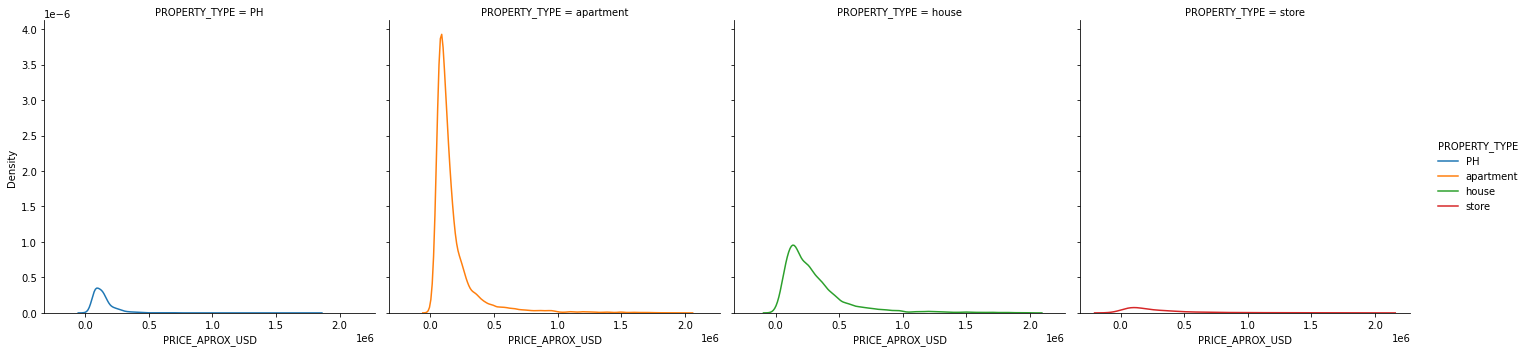

In [ ]:
sns.displot(data=data.loc[data['PRICE_APROX_USD']<2000000], x='PRICE_APROX_USD',hue='PROPERTY_TYPE', col='PROPERTY_TYPE', kind="kde")

plt.show()

In [ ]:
data.shape

(100635, 25)

###**Variable Surface Total y Covered**


Sobre las columnas ``DESCRIPTION`` y ``TITLE``, buscaremos extraer información que puede llegar a ser relevante para completar datos nulos o crear nuevas columnas con características de la propiedad que sean significativas para explicar el precio de la propiedad.

In [ ]:
data[['SURFACE_TOTAL_IN_M2', 'SURFACE_COVERED_IN_M2']].describe()

SURFACE_TOTAL_IN_M2  SURFACE_COVERED_IN_M2
count         67252.000000           86109.000000
mean            223.247398             129.973963
std            1725.789205             752.833426
min               0.000000               0.000000
25%              50.000000              45.000000
50%              83.000000              74.000000
75%             200.000000             150.000000
max          200000.000000          187000.000000

Vemos que hay valores 0 en en ambas columnas que no corresponden, para ello tomaremos como cota inferior $18m^2$ que es considerado por la normativa,

Fuente: codigo de edificación de la ciudad de Buenos Aires https://www.buenosaires.gob.ar/jefaturadegabinete/desarrollo-urbano/normativa/codigos


In [ ]:
print('La columna SURFACE_TOTAL_IN_M2, tiene', data.loc[data['SURFACE_TOTAL_IN_M2']<18].shape[0], 'registros con superficie menor a 18m2')
print('La columna SURFACE_COVERED_IN_M2, tiene', data.loc[data['SURFACE_COVERED_IN_M2']<18].shape[0], 'registros con superficie menor a 18m2')
data.loc[data['SURFACE_TOTAL_IN_M2']<18, 'SURFACE_TOTAL_IN_M2']=np.nan
data.loc[data['SURFACE_COVERED_IN_M2']<18, 'SURFACE_COVERED_IN_M2']=np.nan
#creamos variables logaritmicas para quitar tanta variabilidad en las variables y así poder graficar
data['LOG_SURFACE_TOTAL_IN_M2']=np.log10(data['SURFACE_TOTAL_IN_M2'])
data['LOG_SURFACE_COVERED_IN_M2']=np.log10(data['SURFACE_COVERED_IN_M2'])

La columna SURFACE_TOTAL_IN_M2, tiene 299 registros con superficie menor a 18m2
La columna SURFACE_COVERED_IN_M2, tiene 381 registros con superficie menor a 18m2


Previo a rellenar los nulos en ambas columnas, analizaremos gráficamente la consistencia entre la superficie total y la cubierta, donde la primera debe ser siempre mayor a la segunda.

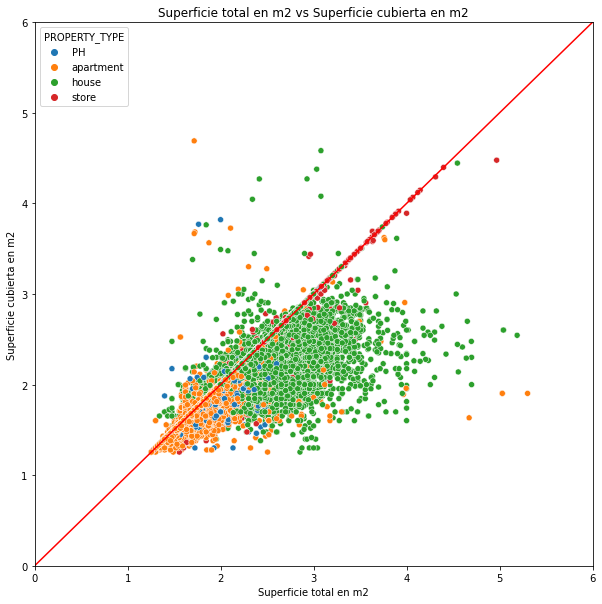

In [ ]:
#graph in scatter plot surfacetotal vs surface covers with a line x=y BY PROPERTY TYPE
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=data['LOG_SURFACE_TOTAL_IN_M2'], y=data['LOG_SURFACE_COVERED_IN_M2'], hue=data['PROPERTY_TYPE'], ax=ax)
ax.set_xlabel('Superficie total en m2')
ax.set_ylabel('Superficie cubierta en m2')
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=6)
ax.set_title('Superficie total en m2 vs Superficie cubierta en m2')
#graph a line x=y
ax.plot([0, 6], [0, 6], transform=ax.transAxes, color='red')
plt.show()

In [ ]:
print('La cantidad de registros donde COVERED es mayor a TOTAL es', data.loc[data['SURFACE_COVERED_IN_M2']>data['SURFACE_TOTAL_IN_M2']].shape[0])


La cantidad de registros donde COVERED es mayor a TOTAL es 869


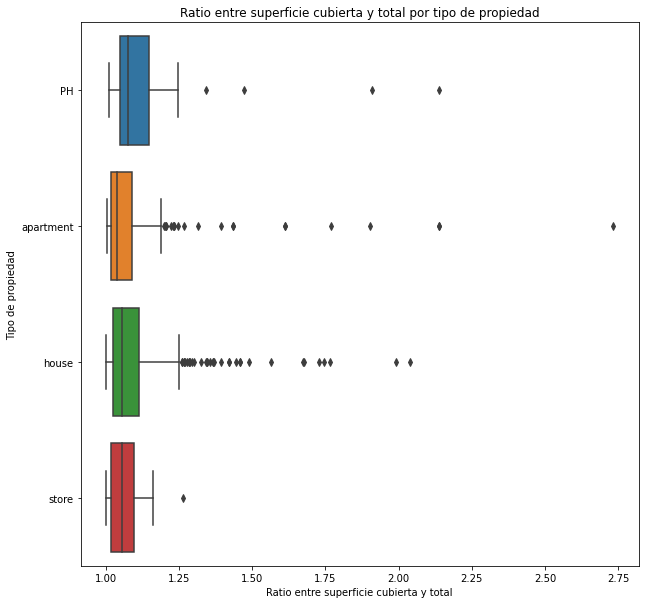

In [ ]:
#crear ua variable que sea el ratio entre cubierta y total
data['RATIO_LOG_COVERED_TOTAL']=data['LOG_SURFACE_COVERED_IN_M2']/data['LOG_SURFACE_TOTAL_IN_M2']
#graficar boxplot de los datos de la columna ratio por tipo de propiedad para los valores donde ratio es mayor a 1
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x=data.loc[data['RATIO_LOG_COVERED_TOTAL']>1, 'RATIO_LOG_COVERED_TOTAL'], y=data.loc[data['RATIO_LOG_COVERED_TOTAL']>1, 'PROPERTY_TYPE'], ax=ax)
ax.set_xlabel('Ratio entre superficie cubierta y total')
ax.set_ylabel('Tipo de propiedad')
ax.set_title('Ratio entre superficie cubierta y total por tipo de propiedad')
plt.show()


Para resolver los datos que se encuentran por encima de la recta de $45°$ procederemos a dropearlos, dado que no encontramos patrones que nos permitan notar que están imputados de forma contraria, es decir, donde va cubierta se imputo total y viceversa, ni tampoco dislucidamos graficamente una relación que nos permita decir que hay una relación proporcional entre cubierta y total en estos valores para reemplazarlas.

In [ ]:
#creamos un dataframe con los registros que contienen los datos de superficie total y cubierta inconsistentes para ver qué patrones vemos en ellos
raros=data.loc[data['SURFACE_COVERED_IN_M2']>data['SURFACE_TOTAL_IN_M2'], ['SURFACE_TOTAL_IN_M2', 'SURFACE_COVERED_IN_M2', 'DESCRIPTION', 'PROPERTY_TYPE']]
ejemplo_no_invertido=raros.iloc[54]
display(ejemplo_no_invertido)
#dropeamos los registros raros
data.drop(raros.index, inplace=True)
#dropeamos los registros de data donde covered es mayor a total
data.drop(data.loc[data['SURFACE_COVERED_IN_M2']>data['SURFACE_TOTAL_IN_M2']].index, inplace=True)
print('El dataset contiene un total de', data.shape[0], 'registros')


SURFACE_TOTAL_IN_M2                                                  185.0
SURFACE_COVERED_IN_M2                                                318.0
DESCRIPTION              venta de casa 3 ambientes en gregorio de lafer...
PROPERTY_TYPE                                                        house
Name: 7719, dtype: object

El dataset contiene un total de 98280 registros


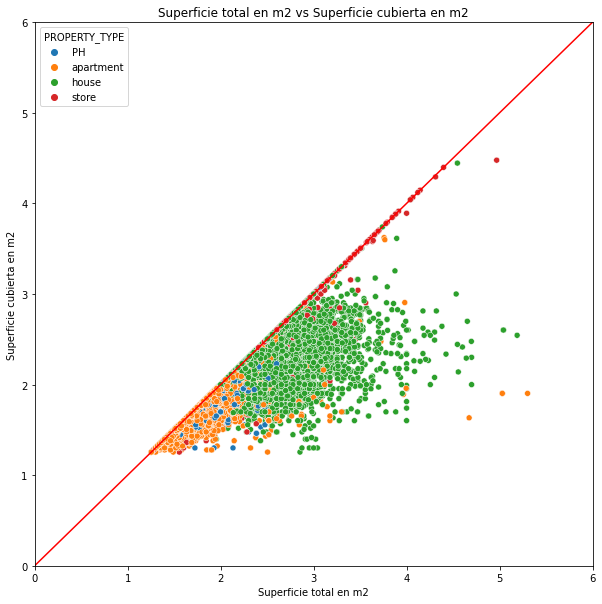

In [ ]:
#graph in scatter plot surfacetotal vs surface covers with a line x=y BY PROPERTY TYPE
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=data['LOG_SURFACE_TOTAL_IN_M2'], y=data['LOG_SURFACE_COVERED_IN_M2'], hue=data['PROPERTY_TYPE'], ax=ax)
ax.set_xlabel('Superficie total en m2')
ax.set_ylabel('Superficie cubierta en m2')
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=6)
ax.set_title('Superficie total en m2 vs Superficie cubierta en m2')
#graph a line x=y
ax.plot([0, 6], [0, 6], transform=ax.transAxes, color='red')
plt.show()

Teniendo un panorama más claro sobre ambas variables comenzamos la limpieza de nulos para ambas variables, superficie total y cubierta

In [ ]:
print('La cantidad de nulos en la columna SURFACE_TOTAL_IN_M2 es', data['SURFACE_TOTAL_IN_M2'].isnull().sum())
print('La cantidad de nulos en la columna SURFACE_COVERED_IN_M2 es', data['SURFACE_COVERED_IN_M2'].isnull().sum())

La cantidad de nulos en la columna SURFACE_TOTAL_IN_M2 es 32196
La cantidad de nulos en la columna SURFACE_COVERED_IN_M2 es 13421


Por tratarse de variables que terminaran formando parte de la variable *target* en nuestros futuros modelos, utilizaremos medidas muy restrictivas para rellenar los nulos en superficie total y cubierta. 

En primer lugar construiremos una métrica, que llamaremos *proxy*, a partir de los datos disponibles en ambas columnas. Esta métrica tendrá por objetivo reflejar la relación proporcional entre la superficie total y la cubierta.
La misma será utilizada en los casos:

1. Donde $SURFACE\_TOTAL\_IN\_M2=nan$ y $SURFACE\_COVERED\_IN\_M2\neq nan$ $\rightarrow$ $SURFACE\_TOTAL\_IN\_M2=\frac{1}{\alpha}SURFACE\_TOTAL\_IN\_M2$
2. Donde $SURFACE\_TOTAL\_IN\_M2\neq nan$ y $SURFACE\_COVERED\_IN\_M2= nan$ $\rightarrow$ $SURFACE\_COVERED\_IN\_M2=\alpha SURFACE\_COVERED\_IN\_M2$
3. Donde $SURFACE\_TOTAL\_IN\_M2= nan$ y $SURFACE\_COVERED\_IN\_M2= nan$ $\rightarrow$ rellenaremos utilizando REGEX y los casas y stores que no puedan ser rellenados con 1 y 2


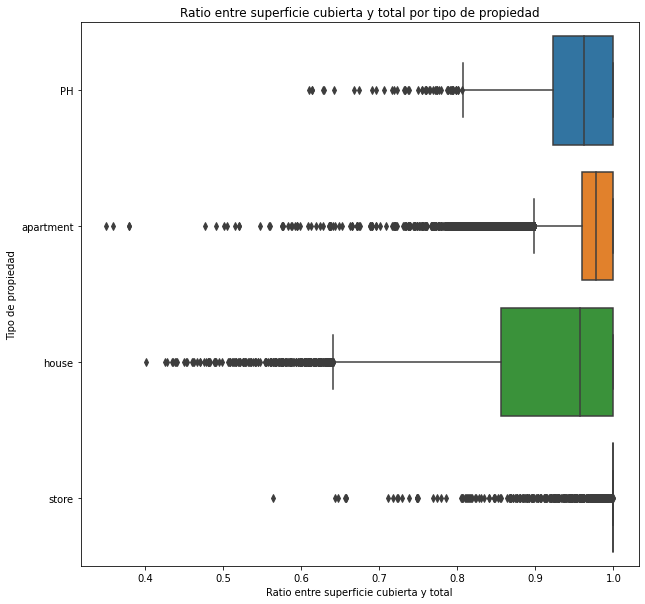

In [ ]:
#Construimos la proxy que llamaremos con el nombre alpha y aplicaremos para las propidades donde la dispersion del ratio de covered y total es baja
#graficar un boxplot del ratio entre log de covered y total por tipo de propiedad
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x=data['RATIO_LOG_COVERED_TOTAL'], y=data['PROPERTY_TYPE'], ax=ax)
ax.set_xlabel('Ratio entre superficie cubierta y total')
ax.set_ylabel('Tipo de propiedad')
ax.set_title('Ratio entre superficie cubierta y total por tipo de propiedad')
plt.show()

In [ ]:
#Podemos ver que la dispersión en el tipo de propiedad PH y apartment no es muy alta, por lo que podemos usar el ratio de covered y total para rellenar los nulos de covered o total
#creamos un objeto que sea la media de la variable ratio log covered total por tipo de propiedad para el tipo de propiedad PH 
alpha_ph=data.loc[data['PROPERTY_TYPE']=='PH', 'RATIO_LOG_COVERED_TOTAL'].mean()
#creamos un objeto que sea la media de la variable ratio log covered total por tipo de propiedad para el tipo de propiedad apartment
alpha_apartment=data.loc[data['PROPERTY_TYPE']=='apartment', 'RATIO_LOG_COVERED_TOTAL'].mean()

#Donde covered sea nan y total no sea nan, rellenamos covered con el valor de total * alpha_ph para el tipo de propiedad PH
data.loc[(data['SURFACE_COVERED_IN_M2'].isnull()) & (data['SURFACE_TOTAL_IN_M2'].notnull()) & (data['PROPERTY_TYPE']=='PH'), 'SURFACE_COVERED_IN_M2']=data.loc[(data['SURFACE_COVERED_IN_M2'].isnull()) & (data['SURFACE_TOTAL_IN_M2'].notnull()) & (data['PROPERTY_TYPE']=='PH'), 'SURFACE_TOTAL_IN_M2']*alpha_ph
#Donde covered no sea nan y total sea nan, rellenamos total con el valor de covered * 1/alpha_ph para el tipo de propiedad PH
data.loc[(data['SURFACE_COVERED_IN_M2'].notnull()) & (data['SURFACE_TOTAL_IN_M2'].isnull()) & (data['PROPERTY_TYPE']=='PH'), 'SURFACE_TOTAL_IN_M2']=data.loc[(data['SURFACE_COVERED_IN_M2'].notnull()) & (data['SURFACE_TOTAL_IN_M2'].isnull()) & (data['PROPERTY_TYPE']=='PH'), 'SURFACE_COVERED_IN_M2']*(1/alpha_ph)

#Donde covered sea nan y total no sea nan, rellenamos covered con el valor de total * alpha_ph para el tipo de propiedad apartment
data.loc[(data['SURFACE_COVERED_IN_M2'].isnull()) & (data['SURFACE_TOTAL_IN_M2'].notnull()) & (data['PROPERTY_TYPE']=='apartment'), 'SURFACE_COVERED_IN_M2']=data.loc[(data['SURFACE_COVERED_IN_M2'].isnull()) & (data['SURFACE_TOTAL_IN_M2'].notnull()) & (data['PROPERTY_TYPE']=='apartment'), 'SURFACE_TOTAL_IN_M2']*alpha_apartment
#Donde covered no sea nan y total sea nan, rellenamos total con el valor de covered * 1/alpha_ph para el tipo de propiedad apartment
data.loc[(data['SURFACE_COVERED_IN_M2'].notnull()) & (data['SURFACE_TOTAL_IN_M2'].isnull()) & (data['PROPERTY_TYPE']=='apartment'), 'SURFACE_TOTAL_IN_M2']=data.loc[(data['SURFACE_COVERED_IN_M2'].notnull()) & (data['SURFACE_TOTAL_IN_M2'].isnull()) & (data['PROPERTY_TYPE']=='apartment'), 'SURFACE_COVERED_IN_M2']*(1/alpha_apartment)

print('La cantidad de nulos en la columna SURFACE_TOTAL_IN_M2 es', data['SURFACE_TOTAL_IN_M2'].isnull().sum())
print('La cantidad de nulos en la columna SURFACE_COVERED_IN_M2 es', data['SURFACE_COVERED_IN_M2'].isnull().sum())

La cantidad de nulos en la columna SURFACE_TOTAL_IN_M2 es 18206
La cantidad de nulos en la columna SURFACE_COVERED_IN_M2 es 9899


In [ ]:
print('La cantidad de registros donde total está nula y covered no es', data.loc[(data['SURFACE_TOTAL_IN_M2'].isna()) & (data['SURFACE_COVERED_IN_M2'].notna())].shape[0])
print('La cantidad de registros donde covered está nula y total no es', data.loc[(data['SURFACE_TOTAL_IN_M2'].notna()) & (data['SURFACE_COVERED_IN_M2'].isna())].shape[0])
print('La cantidad de registros donde ambas variables de superficie son nulas son', data.loc[(data['SURFACE_TOTAL_IN_M2'].isna()) & (data['SURFACE_COVERED_IN_M2'].isna())].shape[0])

La cantidad de registros donde total está nula y covered no es 10048
La cantidad de registros donde covered está nula y total no es 1741
La cantidad de registros donde ambas variables de superficie son nulas son 8158


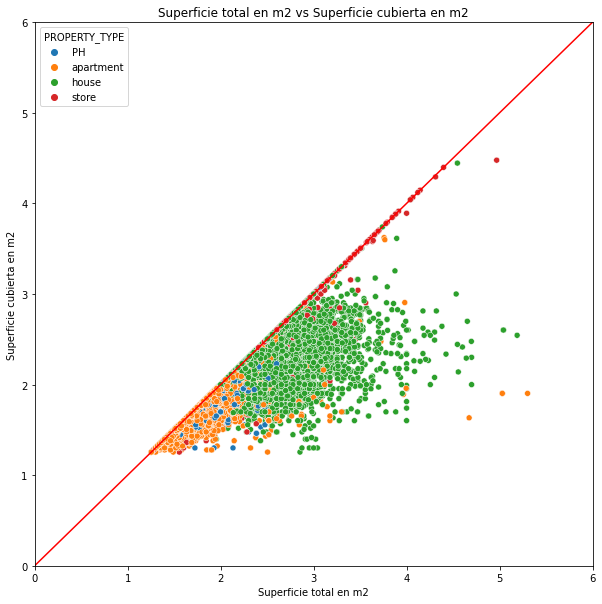

In [ ]:
#graph in scatter plot surfacetotal vs surface covers with a line x=y BY PROPERTY TYPE
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=data['LOG_SURFACE_TOTAL_IN_M2'], y=data['LOG_SURFACE_COVERED_IN_M2'], hue=data['PROPERTY_TYPE'], ax=ax)
ax.set_xlabel('Superficie total en m2')
ax.set_ylabel('Superficie cubierta en m2')
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=6)
ax.set_title('Superficie total en m2 vs Superficie cubierta en m2')
#graph a line x=y
ax.plot([0, 6], [0, 6], transform=ax.transAxes, color='red')
plt.show()

**REGEX SURFACE_TOTAL_IN_M2**


Previo a pasar a rellenar con REGEX las variables de superficie observaremos la distribución de los datos para acercarnos a una imagen de su distribución y correlación con el precio en dólares de la propiedad.

In [ ]:
print('La columna PRICE_APROX_USD, tiene', data.loc[data['PRICE_APROX_USD']==0].shape[0], 'ceros')
display(data.loc[data['PRICE_APROX_USD']==0])
print('Podemos ver que el registro que tiene precio 0, no es posible rellenarlo a partir de las otras columnas, por lo tanto lo dropeamos')
data.drop(data.loc[data['PRICE_APROX_USD']==0].index, inplace=True)
data['LOG_SURFACE_TOTAL_IN_M2']=np.log10(data['SURFACE_TOTAL_IN_M2'])
data['LOG_SURFACE_COVERED_IN_M2']=np.log10(data['SURFACE_COVERED_IN_M2'])
data['LOG_PRICE_APROX_USD']=np.log10(data['PRICE_APROX_USD'])

La columna PRICE_APROX_USD, tiene 0 ceros


Empty DataFrame
Columns: [PROPERTY_TYPE, PLACE_NAME, STATE_NAME, GEONAMES_ID, LAT-LON, LAT, LON, PRICE, CURRENCY, PRICE_APROX_LOCAL_CURRENCY, PRICE_APROX_USD, SURFACE_TOTAL_IN_M2, SURFACE_COVERED_IN_M2, PRICE_USD_PER_M2, PRICE_PER_M2, FLOOR, ROOMS, EXPENSES, PROPERATI_URL, DESCRIPTION, TITLE, CIUDAD, BARRIO, CHEQUEO_PLACE, CHEQUEO_UBICACION, LOG_SURFACE_TOTAL_IN_M2, LOG_SURFACE_COVERED_IN_M2, RATIO_LOG_COVERED_TOTAL]
Index: []

Podemos ver que el registro que tiene precio 0, no es posible rellenarlo a partir de las otras columnas, por lo tanto lo dropeamos


In [ ]:
data['SURFACE_TOTAL_IN_M2'].describe()

count     80074.000000
mean        202.730643
std        1726.665363
min          18.000000
25%          49.000000
50%          76.000000
75%         170.000000
max      200000.000000
Name: SURFACE_TOTAL_IN_M2, dtype: float64

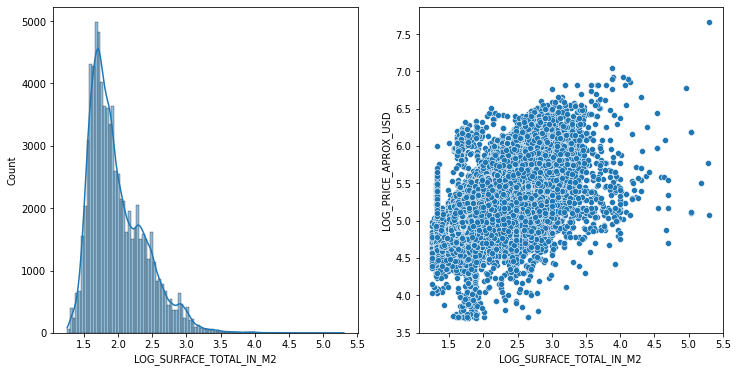

In [ ]:
fig, ax=plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data['LOG_SURFACE_TOTAL_IN_M2'], ax=ax[0], kde=True, bins=100)
sns.scatterplot(x=data['LOG_SURFACE_TOTAL_IN_M2'], y=data['LOG_PRICE_APROX_USD'], ax=ax[1])
plt.show()

In [ ]:
print('Partimos con estos nan', data['SURFACE_TOTAL_IN_M2'].isna().sum())
data.loc[~data['SURFACE_TOTAL_IN_M2'].isna(), 'STAGE_SFT']='0. sin limpieza'
data['SURFACE_TOTAL_IN_M2']=data['SURFACE_TOTAL_IN_M2'].fillna(data['DESCRIPTION'].str.findall(r'\s{1}(\d{1,3})\s{0,1}(?:m|m2|mts2|mts|metros|metros2|metros cuadrados|metros cuadrado|metros cuadrados|m²)\s{1}tot').str[0])
print('1. Los nan bajan a ', data['SURFACE_TOTAL_IN_M2'].isna().sum())
data.loc[(~data['SURFACE_TOTAL_IN_M2'].isna()) & (data['STAGE_SFT'].isna()), 'STAGE_SFT']='1. limpieza 1'
data['SURFACE_TOTAL_IN_M2']=data['SURFACE_TOTAL_IN_M2'].fillna(data['TITLE'].str.findall(r'\s{1}(\d{1,3})\s{0,1}(?:m|m2|mts2|mts|metros|metros2|metros cuadrados|metros cuadrado|metros cuadrados|m²)\s{1}tot').str[0])
print('2. Los nan bajan a ', data['SURFACE_TOTAL_IN_M2'].isna().sum())
data.loc[(~data['SURFACE_TOTAL_IN_M2'].isna()) & (data['STAGE_SFT'].isna()), 'STAGE_SFT']='2. limpieza 2'
data['SURFACE_TOTAL_IN_M2']=data['SURFACE_TOTAL_IN_M2'].fillna(data['DESCRIPTION'].str.findall(r'\s{0,1}(?:tot\.?\:?|total\.?\:?)\s{1}(\d{1,3})\s{0,1}(?:m|m2|mts2|mts|metros|metros2|metros cuadrados|metros cuadrado|metros cuadrados|m²)').str[0])
print('3. Los nan bajan a ', data['SURFACE_TOTAL_IN_M2'].isna().sum())
data.loc[(~data['SURFACE_TOTAL_IN_M2'].isna()) & (data['STAGE_SFT'].isna()), 'STAGE_SFT']='3. limpieza 3'
data['SURFACE_TOTAL_IN_M2']=data['SURFACE_TOTAL_IN_M2'].fillna(data['TITLE'].str.findall(r'\s{0,1}(?:tot\.?\:?|total\.?\:?)\s{1}(\d{1,3})\s{0,1}(?:m|m2|mts2|mts|metros|metros2|metros cuadrados|metros cuadrado|metros cuadrados|m²)').str[0])
print('4. Los nan bajan a ', data['SURFACE_TOTAL_IN_M2'].isna().sum())
data.loc[(~data['SURFACE_TOTAL_IN_M2'].isna()) & (data['STAGE_SFT'].isna()), 'STAGE_SFT']='4. limpieza 4'

Partimos con estos nan 18206
1. Los nan bajan a  18077
2. Los nan bajan a  18075
3. Los nan bajan a  17884
4. Los nan bajan a  17883


In [ ]:
data['SURFACE_TOTAL_IN_M2']=pd.to_numeric(data['SURFACE_TOTAL_IN_M2'], errors='coerce')
print(data['SURFACE_TOTAL_IN_M2'].isna().sum())
data.loc[data['SURFACE_TOTAL_IN_M2']<18, 'SURFACE_TOTAL_IN_M2']=np.nan
print(data['SURFACE_TOTAL_IN_M2'].isna().sum())
data['LOG_SURFACE_TOTAL_IN_M2']=np.log10(data['SURFACE_TOTAL_IN_M2'])

17883
17886


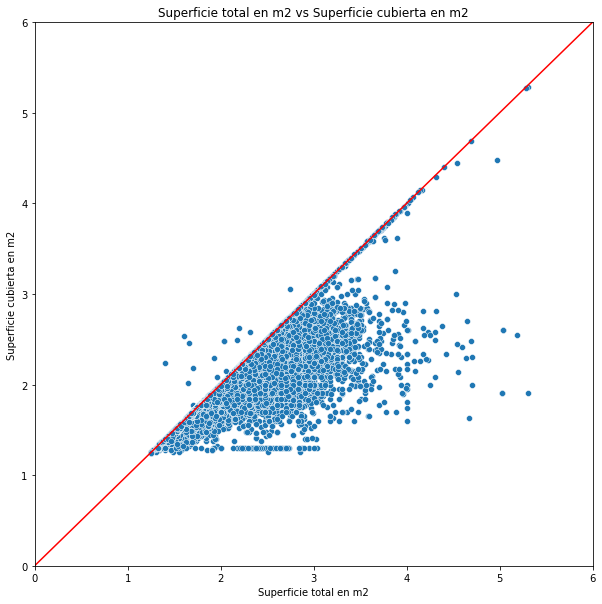

In [ ]:
#chequeamos nuevamente consistencia
#graph in scatter plot surfacetotal vs surface covers with a line x=y
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=data['LOG_SURFACE_TOTAL_IN_M2'], y=data['LOG_SURFACE_COVERED_IN_M2'], ax=ax)
ax.set_xlabel('Superficie total en m2')
ax.set_ylabel('Superficie cubierta en m2')
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=6)
ax.set_title('Superficie total en m2 vs Superficie cubierta en m2')
#graph a line x=y
ax.plot([0, 6], [0, 6], transform=ax.transAxes, color='red')
plt.show()

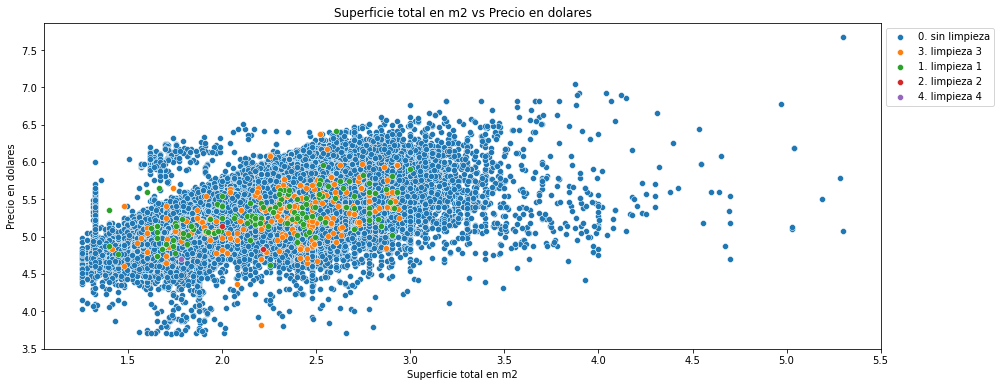

In [ ]:
#Con este gráfico buscamos visualizar la forma en que los datos entran a medida que aplicamos regex
#scatter de la superficie total en m2 vs el precio en dolares por cada stage_sft
fig, ax = plt.subplots(figsize=(15, 6))
for stage in data['STAGE_SFT'].unique():
    sns.scatterplot(x=data.loc[data['STAGE_SFT']==stage, 'LOG_SURFACE_TOTAL_IN_M2'], y=data.loc[data['STAGE_SFT']==stage, 'LOG_PRICE_APROX_USD'], label=stage, ax=ax)
ax.set_xlabel('Superficie total en m2')
ax.set_ylabel('Precio en dolares')
ax.set_title('Superficie total en m2 vs Precio en dolares')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

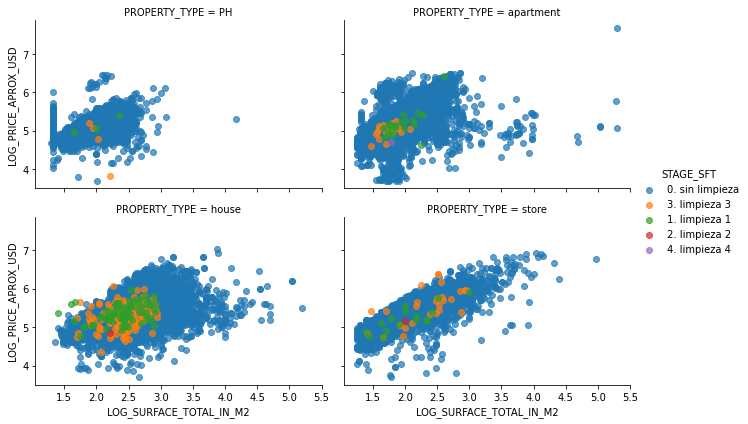

In [ ]:
#FACEFGRID with graph above by propery type by stage_sft
g = sns.FacetGrid(data, col="PROPERTY_TYPE", hue="STAGE_SFT", col_wrap=2, height=3, aspect=1.5)
g.map(plt.scatter, "LOG_SURFACE_TOTAL_IN_M2", "LOG_PRICE_APROX_USD", alpha=.7)
g.add_legend()
plt.show()

Text(0.5, 0.98, 'Superficie total en m2 por etapa')

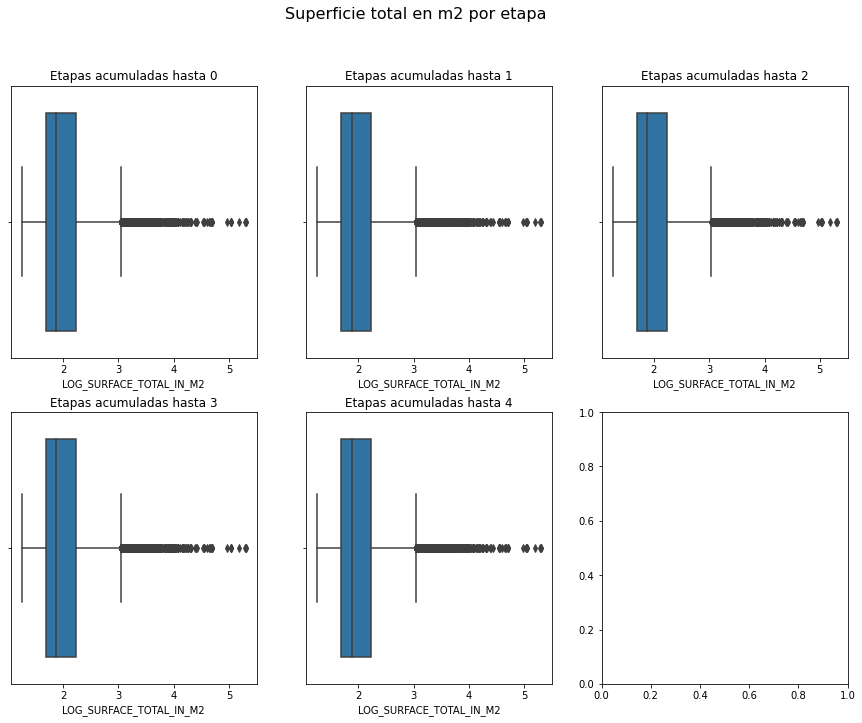

In [ ]:
#Con este gráfico busamos mostrar la varibilidad que se incorpora a medida que ingresan datos con regex
fig, ax = plt.subplots(2,3, figsize=(15, 11))
stages=[]
for n, stage in enumerate(data['STAGE_SFT'].dropna().unique()):
    stages.append(stage)
    sns.boxplot(ax=ax[n//3,n%3], data=data.loc[data['STAGE_SFT'].isin(stages)], x="LOG_SURFACE_TOTAL_IN_M2")
#title for each boxplot
    ax[n//3,n%3].set_title('Etapas acumuladas hasta '+ str(n))
#title for the whole figure
fig.suptitle('Superficie total en m2 por etapa', fontsize=16)



**REGEX SURFACE_COVERED_IN_M2**


In [ ]:
data['SURFACE_COVERED_IN_M2'].describe()

count     88381.000000
mean        127.712278
std         970.523990
min          17.445684
25%          45.000000
50%          72.000000
75%         145.000000
max      193840.933145
Name: SURFACE_COVERED_IN_M2, dtype: float64

In [ ]:
print('La columna SURFACE_COVERED_IN_M2, tiene', data.loc[data['SURFACE_COVERED_IN_M2']<18].shape[0], 'registros con superficie menor a 18m2')
#CODIGO DE EDIFICACION DE LA CIUDAD DE BUENOS AIRES, FUENTE: https://www.buenosaires.gob.ar/jefaturadegabinete/desarrollo-urbano/normativa/codigos
data.loc[data['SURFACE_COVERED_IN_M2']<18, 'SURFACE_COVERED_IN_M2']=np.nan
data['LOG_SURFACE_COVERED_IN_M2']=np.log10(data['SURFACE_COVERED_IN_M2'])


La columna SURFACE_COVERED_IN_M2, tiene 5 registros con superficie menor a 18m2


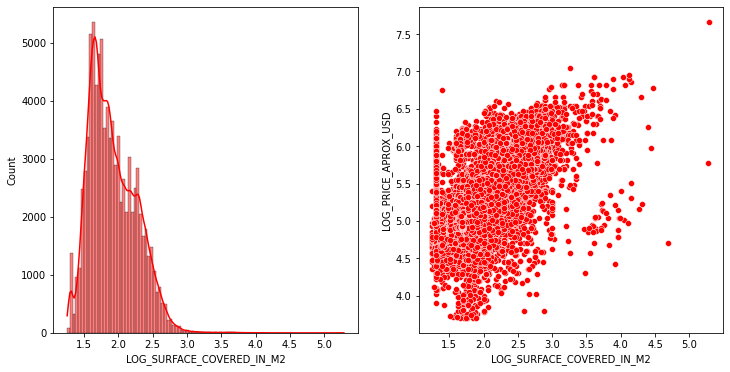

In [ ]:
fig, ax=plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data['LOG_SURFACE_COVERED_IN_M2'], ax=ax[0], kde=True, bins=100, color='red')
sns.scatterplot(x=data['LOG_SURFACE_COVERED_IN_M2'], y=data['LOG_PRICE_APROX_USD'], ax=ax[1], color='red')
plt.show()

In [ ]:
print('Partimos con estos nan', data['SURFACE_COVERED_IN_M2'].isna().sum())
data.loc[~data['SURFACE_COVERED_IN_M2'].isna(), 'STAGE_SFC']='0. sin limpieza'
data['SURFACE_COVERED_IN_M2']=data['SURFACE_COVERED_IN_M2'].fillna(data['DESCRIPTION'].str.findall(r'\s{1}(\d{1,3})\s{0,1}(?:m|m2|mts2|mts|metros|metros2|metros cuadrados|metros cuadrado|metros cuadrados|m²)\s{1}(?:cub|semicub|semi cub|inter)').str[0])
print('1. Los nan bajan a ', data['SURFACE_COVERED_IN_M2'].isna().sum())
data.loc[(~data['SURFACE_COVERED_IN_M2'].isna()) & (data['STAGE_SFC'].isna()), 'STAGE_SFC']='1. limpieza 1'
data['SURFACE_COVERED_IN_M2']=data['SURFACE_COVERED_IN_M2'].fillna(data['TITLE'].str.findall(r'\s{1}(\d{1,3})\s{0,1}(?:m|m2|mts2|mts|metros|metros2|metros cuadrados|metros cuadrado|metros cuadrados|m²)\s{1}(?:cub|semicub|semi cub|inter)').str[0])
print('2. Los nan bajan a ', data['SURFACE_COVERED_IN_M2'].isna().sum())
data.loc[(~data['SURFACE_COVERED_IN_M2'].isna()) & (data['STAGE_SFC'].isna()), 'STAGE_SFC']='2. limpieza 2'
data['SURFACE_COVERED_IN_M2']=data['SURFACE_COVERED_IN_M2'].fillna(data['DESCRIPTION'].str.findall(r'\s{1}(\d{1,3}\,?\.?\d{1,2})\s{0,1}(?:m|m2|mts2|mts|metros|metros2|metros cuadrados|metros cuadrado|metros cuadrados|m²)\s{1}(?:cub|semicub|semi cub|inter)').str[0])
print('3. Los nan bajan a ', data['SURFACE_COVERED_IN_M2'].isna().sum())
data.loc[(~data['SURFACE_COVERED_IN_M2'].isna()) & (data['STAGE_SFC'].isna()), 'STAGE_SFC']='3. limpieza 3'
data['SURFACE_COVERED_IN_M2']=data['SURFACE_COVERED_IN_M2'].fillna(data['TITLE'].str.findall(r'\s{1}(\d{1,3})\s{0,1}(?:m|m2|mts2|mts|metros|metros2|metros cuadrados|metros cuadrado|metros cuadrados|m²)\s{1}(?:cub|semicub|semi cub|inter)').str[0])
print('4. Los nan bajan a ', data['SURFACE_COVERED_IN_M2'].isna().sum())
data.loc[(~data['SURFACE_COVERED_IN_M2'].isna()) & (data['STAGE_SFC'].isna()), 'STAGE_SFC']='4. limpieza 4'
data['SURFACE_COVERED_IN_M2']=data['SURFACE_COVERED_IN_M2'].fillna(data['DESCRIPTION'].str.findall(r'\s{0,1}(?:cub\.?\:?|semicub\.?\:?|semi cub\.?\:?|inter\.?\:?)\s{1}(\d{1,3})\s{0,1}(?:m|m2|mts2|mts|metros|metros2|metros cuadrados|metros cuadrado|metros cuadrados|m²)').str[0])
print('5. Los nan bajan a ', data['SURFACE_COVERED_IN_M2'].isna().sum())
data.loc[(~data['SURFACE_COVERED_IN_M2'].isna()) & (data['STAGE_SFC'].isna()), 'STAGE_SFC']='5. limpieza 5'

Partimos con estos nan 9904
1. Los nan bajan a  9683
2. Los nan bajan a  9682
3. Los nan bajan a  9666
4. Los nan bajan a  9666
5. Los nan bajan a  9631


In [ ]:
data['SURFACE_COVERED_IN_M2']=pd.to_numeric(data['SURFACE_COVERED_IN_M2'], errors='coerce')
print(data['SURFACE_COVERED_IN_M2'].isna().sum())
data.loc[data['SURFACE_COVERED_IN_M2']<18, 'SURFACE_COVERED_IN_M2']=np.nan
print(data['SURFACE_COVERED_IN_M2'].isna().sum())
data['LOG_SURFACE_COVERED_IN_M2']=np.log10(data['SURFACE_COVERED_IN_M2'])

9637
9642


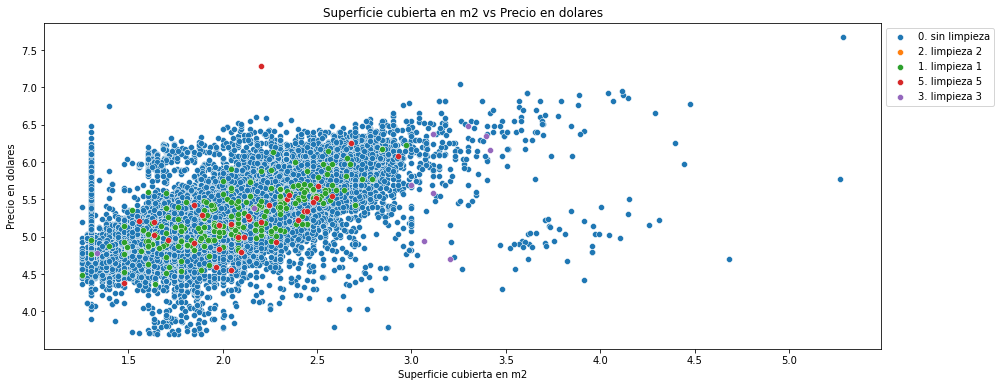

In [ ]:
#scatter de la superficie total en m2 vs el precio en dolares por cada stage_sft
fig, ax = plt.subplots(figsize=(15, 6))
for stage in data['STAGE_SFC'].unique():
    sns.scatterplot(x=data.loc[data['STAGE_SFC']==stage, 'LOG_SURFACE_COVERED_IN_M2'], y=data.loc[data['STAGE_SFC']==stage, 'LOG_PRICE_APROX_USD'], label=stage, ax=ax)
ax.set_xlabel('Superficie cubierta en m2')
ax.set_ylabel('Precio en dolares')
ax.set_title('Superficie cubierta en m2 vs Precio en dolares')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

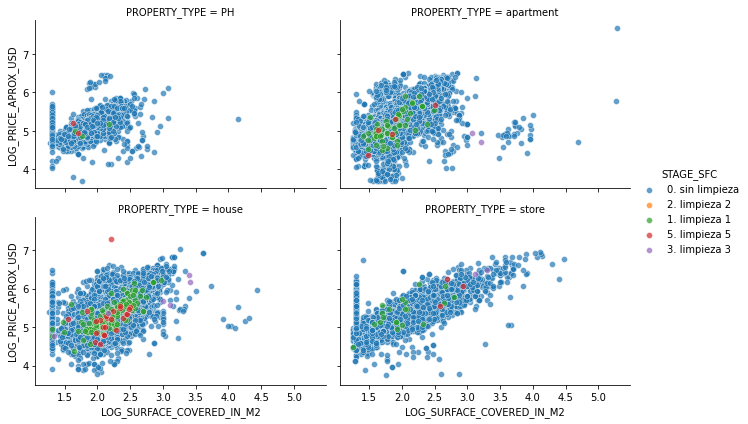

In [ ]:
#FACEFGRID with graph above by propery type by stage_sfC
g = sns.FacetGrid(data, col="PROPERTY_TYPE", hue="STAGE_SFC", col_wrap=2, height=3, aspect=1.5)
g.map(sns.scatterplot, "LOG_SURFACE_COVERED_IN_M2", "LOG_PRICE_APROX_USD", alpha=.7)
g.add_legend()
plt.show()

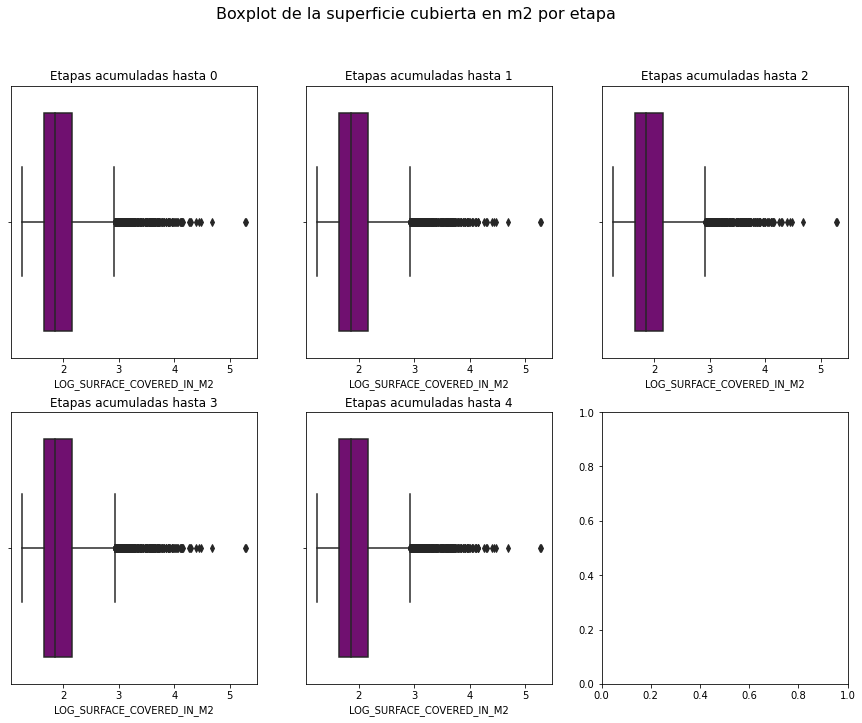

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(15, 11))
stages=[]
#create a list with the unique values from the column STAGE_SFT excluding the nan values
for n, stage in enumerate(data['STAGE_SFC'].dropna().unique()):
    stages.append(stage)
    sns.boxplot(ax=ax[n//3,n%3], data=data.loc[data['STAGE_SFC'].isin(stages)], x="LOG_SURFACE_COVERED_IN_M2", color='purple')
#title for each boxplot
    ax[n//3,n%3].set_title('Etapas acumuladas hasta '+ str(n))
#titlos al grafico total
fig.suptitle('Boxplot de la superficie cubierta en m2 por etapa', fontsize=16)
plt.show()

**CONSISTENCIA**

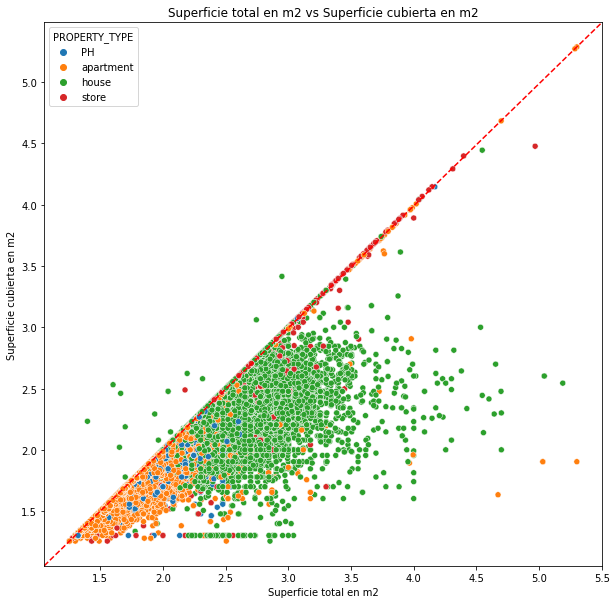

In [ ]:
#graph in scatter plot surfacetotal vs surface covers with a line x=y
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=data['LOG_SURFACE_TOTAL_IN_M2'], y=data['LOG_SURFACE_COVERED_IN_M2'], hue=data['PROPERTY_TYPE'],ax=ax)
ax.set_xlabel('Superficie total en m2')
ax.set_ylabel('Superficie cubierta en m2')
ax.set_title('Superficie total en m2 vs Superficie cubierta en m2')
ax.plot([0, 5], [0, 5], transform=ax.transAxes, ls='--', c='r')
plt.show()


In [ ]:
#Nuevamente contabilizar los registros que se encuentran por encima de la recta x=y
print('Los registros que se encuentran por encima de la recta x=y son: ', data.loc[data['LOG_SURFACE_COVERED_IN_M2']>data['LOG_SURFACE_TOTAL_IN_M2']].shape[0])
#Dado que no es posible realizar un tratamiento sobre los registros que esten entrando por encima de la recta de 45° decidimos droppearlos
data.drop(data.loc[data['LOG_SURFACE_COVERED_IN_M2']>data['LOG_SURFACE_TOTAL_IN_M2']].index, inplace=True)
print('Los registros que se encuentran por encima de la recta x=y son: ', data.loc[data['LOG_SURFACE_COVERED_IN_M2']>data['LOG_SURFACE_TOTAL_IN_M2']].shape[0])


Los registros que se encuentran por encima de la recta x=y son:  20
Los registros que se encuentran por encima de la recta x=y son:  0


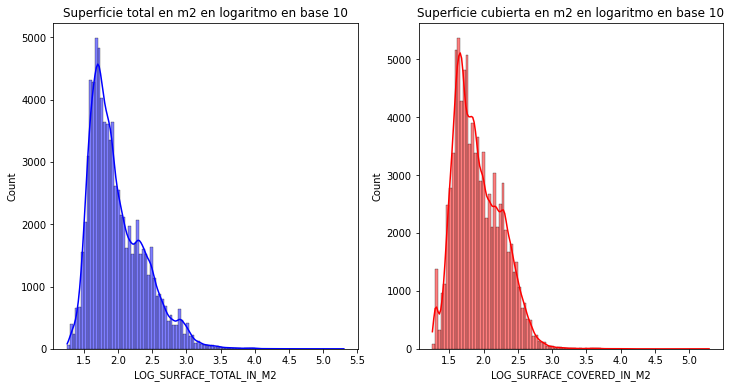

In [ ]:
fig, ax=plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data['LOG_SURFACE_TOTAL_IN_M2'], ax=ax[0], kde=True, bins=100, color='blue')
sns.histplot(data['LOG_SURFACE_COVERED_IN_M2'], ax=ax[1], kde=True, bins=100, color='red')
#TITLOS
ax[0].set_title('Superficie total en m2 en logaritmo en base 10')
ax[1].set_title('Superficie cubierta en m2 en logaritmo en base 10')
plt.show()

In [ ]:
info_nulos.loc[['SURFACE_TOTAL_IN_M2', 'SURFACE_COVERED_IN_M2']]

NameError: ignored

In [ ]:
#teniendo más data sobre la superficie total y cubierta, podemos calcular el precio por m2 total y cubierto que estan nulos
data['PRICE_USD_PER_M2']=data['PRICE_USD_PER_M2'].fillna(data['PRICE_APROX_USD']/data['SURFACE_TOTAL_IN_M2'])
data['PRICE_PER_M2']=data['PRICE_PER_M2'].fillna(data['PRICE_APROX_USD']/data['SURFACE_COVERED_IN_M2'])

In [ ]:
surf_price_nulos_post_limpieza = pd.DataFrame({'nulos': data.isna().sum(), 'porcentaje' : (data.isna().sum()) / data.isna().count() * 100})
surf_price_nulos_post_limpieza.loc[['SURFACE_TOTAL_IN_M2', 'PRICE_USD_PER_M2', 'SURFACE_COVERED_IN_M2', 'PRICE_PER_M2']]

nulos  porcentaje
SURFACE_TOTAL_IN_M2    17886   18.202727
PRICE_USD_PER_M2       17838   18.153877
SURFACE_COVERED_IN_M2   9642    9.812742
PRICE_PER_M2            9322    9.487075

###**Variable Floor**


Sobre las columnas ``DESCRIPTION`` y ``TITLE``, buscaremos extraer información que puede llegar a ser relevante para completar datos nulos o crear nuevas columnas con caracteríristas de la propiedad que sean significativas para explicar el precio de la propiedad.



In [ ]:
data['FLOOR']=pd.to_numeric(data['FLOOR'], errors='coerce')
for i in data['PROPERTY_TYPE'].unique():
    print('La propiedad tipo', i, 'tiene un total de nan values en la columna FLOOR de', data[data['PROPERTY_TYPE']==i]['FLOOR'].isna().sum())
print('------------------------------------------------------------------------------------------------------------------')
print('El tratamiendo para rellenar dichos nulos será distinto dependiendo el tipo de propiedad')

La propiedad tipo PH tiene un total de nan values en la columna FLOOR de 4789
La propiedad tipo apartment tiene un total de nan values en la columna FLOOR de 52093
La propiedad tipo house tiene un total de nan values en la columna FLOOR de 31377
La propiedad tipo store tiene un total de nan values en la columna FLOOR de 3113
------------------------------------------------------------------------------------------------------------------
El tratamiendo para rellenar dichos nulos será distinto dependiendo el tipo de propiedad


Para ``PROPERTY_TYPE=='house'``

In [ ]:
#Rellenamos los nan values en floor, buscando con regex las palabras piso/planta y el numero en la columna description
print('Los nulos en house son', data[data['PROPERTY_TYPE']=='house']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='house') & data['FLOOR'].isna() & data['TITLE'].str.contains('duplex|dúplex|dos plantas', case=False, regex=True), 'FLOOR']=2
data.loc[(data['PROPERTY_TYPE']=='house') & data['FLOOR'].isna() & data['TITLE'].str.contains('planta alta & planta baja', case=False, regex=True), 'FLOOR']=2
print('Los nulos en house son', data[data['PROPERTY_TYPE']=='house']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='house') & data['FLOOR'].isna() & data['DESCRIPTION'].str.contains('planta alta & planta baja', case=False, regex=True), 'FLOOR']=2
data.loc[(data['PROPERTY_TYPE']=='house') & data['FLOOR'].isna() & data['DESCRIPTION'].str.contains('duplex|dúplex|dos plantas', case=False, regex=True), 'FLOOR']=2
print('Los nulos en house son', data[data['PROPERTY_TYPE']=='house']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='house') & data['FLOOR'].isna(), 'FLOOR']=data['TITLE'].str.findall(r'\s{0,1}((?:\d{1,2}|un?a|dos|tres|cuatro))\s{0,1}(?:planta?s|piso?s)').str[0].replace({'un': '1',  'una': '1','dos': '2', 'tres':'3', 'cuatro':'4'})
print('Los nulos en house son', data[data['PROPERTY_TYPE']=='house']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='house') & data['FLOOR'].isna(), 'FLOOR']=data['DESCRIPTION'].str.findall(r'\s{0,1}((?:\d{1,2}|un?a|dos|tres|cuatro))\s{0,1}(?:planta?s|piso?s)').str[0].replace({'un': '1',  'una': '1','dos': '2', 'tres':'3', 'cuatro':'4'})
print('Los nulos en house son', data[data['PROPERTY_TYPE']=='house']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='house') & data['FLOOR'].isna() & data['DESCRIPTION'].str.contains('planta alta', case=False, regex=True), 'FLOOR']=2
data.loc[(data['PROPERTY_TYPE']=='house') & data['FLOOR'].isna() & data['DESCRIPTION'].str.contains('planta baja', case=False, regex=True), 'FLOOR']=1
print('Los nulos en house son', data[data['PROPERTY_TYPE']=='house']['FLOOR'].isna().sum())


Los nulos en house son 31377
Los nulos en house son 30361
Los nulos en house son 25707
Los nulos en house son 24894
Los nulos en house son 22189
Los nulos en house son 16907


Para ``PROPERTY_TYPE=='apartment'``

In [ ]:
print('Los nulos en apartment son', data[data['PROPERTY_TYPE']=='apartment']['FLOOR'].isna().sum())


data.loc[(data['PROPERTY_TYPE']=='apartment') & data['FLOOR'].isna(), 'FLOOR']=data['TITLE'].str.findall(r'\s{0,1}((?:primera?o?|segunda?o?|tercera?o?|cuarta?o?|quinta?o?|sexta?o?|septima?o?|séptimo|décimo?a?))\s{1}(?:piso|planta)').str[0].replace(
{'primer':'1', 'primero':'1','primera':'1',
'segund':'2','segundo':'2','segunda':'2',
'tercer':'3','tercero':'3','tercera':'3',
'cuarto':'4','cuarta':'4', 'cuart':'4',
'quinta':'5','quinto':'5', 'quint':'5', 
'sext':'6','sexta':'6','sexto':'6',
'séptimo':'7','septima':'7','septimo':'7','septim':'7',
'décimo':'10','décima':'10','décimo':'10','décim':'10'})

print('Los nulos en apartment son', data[data['PROPERTY_TYPE']=='apartment']['FLOOR'].isna().sum())

data.loc[(data['PROPERTY_TYPE']=='apartment') & data['FLOOR'].isna(), 'FLOOR']=data['DESCRIPTION'].str.findall(r'\s{0,1}((?:primera?o?|segunda?o?|tercera?o?|cuarta?o?|quinta?o?|sexta?o?|septima?o?|séptimo|décimo?a?))\s{1}(?:piso|planta)').str[0].replace(
{'primer':'1', 'primero':'1','primera':'1',
'segund':'2','segundo':'2','segunda':'2',
'tercer':'3','tercero':'3','tercera':'3',
'cuarto':'4','cuarta':'4', 'cuart':'4',
'quinta':'5','quinto':'5', 'quint':'5', 
'sext':'6','sexta':'6','sexto':'6',
'séptimo':'7','septima':'7','septimo':'7','septim':'7',
'décimo':'10','décima':'10','décimo':'10','décim':'10'})

print('Los nulos en apartment son', data[data['PROPERTY_TYPE']=='apartment']['FLOOR'].isna().sum())


data.loc[(data['PROPERTY_TYPE']=='apartment') & data['FLOOR'].isna(), 'FLOOR']=data['TITLE'].str.findall(r'\s{0,1}(\d{1,2})\°*\s{0,1}(?:planta|piso)').str[0]
print('Los nulos en apartment son', data[data['PROPERTY_TYPE']=='apartment']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='apartment') & data['FLOOR'].isna(), 'FLOOR']=data['DESCRIPTION'].str.findall(r'\s{0,1}(\d{1,2})\°*\s{0,1}(?:planta|piso)').str[0]
print('Los nulos en apartment son', data[data['PROPERTY_TYPE']=='apartment']['FLOOR'].isna().sum())


data.loc[(data['PROPERTY_TYPE']=='apartment') & data['FLOOR'].isna(), 'FLOOR']=data['TITLE'].str.findall(r'(?:planta|piso)\s{1}(\d{1,2})\°*\s{1}').str[0]
print('Los nulos en apartment son', data[data['PROPERTY_TYPE']=='apartment']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='apartment') & data['FLOOR'].isna(), 'FLOOR']=data['DESCRIPTION'].str.findall(r'(?:planta|piso)\s{1}(\d{1,2})\°*\s{1}').str[0]
print('Los nulos en apartment son', data[data['PROPERTY_TYPE']=='apartment']['FLOOR'].isna().sum())




Los nulos en apartment son 52093
Los nulos en apartment son 52012
Los nulos en apartment son 48785
Los nulos en apartment son 48560
Los nulos en apartment son 42295
Los nulos en apartment son 41899
Los nulos en apartment son 41008


Para ``PROPERTY_TYPE=='PH'``

In [ ]:
print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())


data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna(), 'FLOOR']=data['TITLE'].str.findall(r'\s{0,1}((?:primera?o?|segunda?o?|tercera?o?|cuarta?o?|quinta?o?|sexta?o?|septima?o?|séptimo|décimo?a?))\s{1}(?:piso|planta)').str[0].replace(
{'primer':'1', 'primero':'1','primera':'1',
'segund':'2','segundo':'2','segunda':'2',
'tercer':'3','tercero':'3','tercera':'3',
'cuarto':'4','cuarta':'4', 'cuart':'4',
'quinta':'5','quinto':'5', 'quint':'5', 
'sext':'6','sexta':'6','sexto':'6',
'séptimo':'7','septima':'7','septimo':'7','septim':'7',
'décimo':'10','décima':'10','décimo':'10','décim':'10'})

print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())

data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna(), 'FLOOR']=data['DESCRIPTION'].str.findall(r'\s{0,1}((?:primera?o?|segunda?o?|tercera?o?|cuarta?o?|quinta?o?|sexta?o?|septima?o?|séptimo|décimo?a?))\s{1}(?:piso|planta)').str[0].replace(
{'primer':'1', 'primero':'1','primera':'1',
'segund':'2','segundo':'2','segunda':'2',
'tercer':'3','tercero':'3','tercera':'3',
'cuarto':'4','cuarta':'4', 'cuart':'4',
'quinta':'5','quinto':'5', 'quint':'5', 
'sext':'6','sexta':'6','sexto':'6',
'séptimo':'7','septima':'7','septimo':'7','septim':'7',
'décimo':'10','décima':'10','décimo':'10','décim':'10'})

print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())


data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna(), 'FLOOR']=data['TITLE'].str.findall(r'\s{0,1}(\d{1,2})\°*\s{0,1}(?:planta|piso)').str[0]
print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna(), 'FLOOR']=data['DESCRIPTION'].str.findall(r'\s{0,1}(\d{1,2})\°*\s{0,1}(?:planta|piso)').str[0]
print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())


data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna(), 'FLOOR']=data['TITLE'].str.findall(r'(?:planta|piso)\s{1}(\d{1,2})\°*\s{1}').str[0]
print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna(), 'FLOOR']=data['DESCRIPTION'].str.findall(r'(?:planta|piso)\s{1}(\d{1,2})\°*\s{1}').str[0]
print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())

print('------------------------------------------')


print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna() & data['TITLE'].str.contains('duplex|dúplex|dos plantas', case=False, regex=True), 'FLOOR']=2
print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna() & data['DESCRIPTION'].str.contains('duplex|dúplex|dos plantas', case=False, regex=True), 'FLOOR']=2
print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())

print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna() & data['TITLE'].str.contains('triplex|tríplex|tres plantas', case=False, regex=True), 'FLOOR']=2
print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())
data.loc[(data['PROPERTY_TYPE']=='PH') & data['FLOOR'].isna() & data['DESCRIPTION'].str.contains('triplex|tríplex|tres plantas', case=False, regex=True), 'FLOOR']=2
print('Los nulos en PH son', data[data['PROPERTY_TYPE']=='PH']['FLOOR'].isna().sum())


Los nulos en PH son 4789
Los nulos en PH son 4761
Los nulos en PH son 4132
Los nulos en PH son 4078
Los nulos en PH son 3737
Los nulos en PH son 3736
Los nulos en PH son 3724
------------------------------------------
Los nulos en PH son 3724
Los nulos en PH son 3523
Los nulos en PH son 3240
Los nulos en PH son 3240
Los nulos en PH son 3224
Los nulos en PH son 3198


Notar que según el tipo de propiedad la variable ``DESCRIPTION`` tiene un significado distinto, para departamentos significa en el piso donde está ubicado en el edificio, mientras que para las casa esta variable refiere a la cantidad de plantas que la misma posee.

In [ ]:
data['FLOOR']=pd.to_numeric(data['FLOOR'], errors='coerce')

In [ ]:
data.FLOOR.describe()

count    34034.000000
mean         7.023124
std         55.799810
min          0.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2509.000000
Name: FLOOR, dtype: float64

In [ ]:
data[data.FLOOR > 50].shape

(294, 31)

###**Variable Rooms**

Sobre las columnas ``DESCRIPTION`` y ``TITLE``, buscaremos extraer información que puede llegar a ser relevante para completar datos nulos en la variable Rooms

In [ ]:
data['ROOMS']=pd.to_numeric(data['ROOMS'], errors='coerce')

print('Los nulos', data['ROOMS'].isna().sum())
data['ROOMS']=data['ROOMS'].fillna(data['TITLE'].str.findall(r'\s{0,1}((?:\d{1,2}|un|dos|tres|cuatro|cinco|seis|siete|ocho))\s{1}amb').str[0]).replace({'un': '1', 'dos': '2', 'tres':'3', 'cuatro':'4', 'cinco':'5', 'seis':'6', 'siete':'7', 'ocho':'8'})
print('Los nulos con 1', data['ROOMS'].isna().sum())
data['ROOMS']=data['ROOMS'].fillna(data['TITLE'].str.findall(r'\s{0,1}((?:\d{1,2}|un|dos|tres|cuatro|cinco|seis|siete|ocho))\s{1}(?:dorm|habit|cuart)').str[0]).replace({'un':'2', 'dos':'3', 'tres':'4', 'cuatro':'5', 'cinco':'6', 'seis':'7', 'siete':'8', 'ocho':'9'})
print('Los nulos con 2', data['ROOMS'].isna().sum())
data['ROOMS']=data['ROOMS'].fillna(data['DESCRIPTION'].str.findall(r'\s{0,1}((?:\d{1,2}|un|dos|tres|cuatro|cinco|seis|siete|ocho))\s{1}amb').str[0]).replace({'un':'1', 'dos':'2', 'tres':'3', 'cuatro':'4', 'cinco':'5', 'seis':'6', 'siete':'7', 'ocho':'8'})
print('Los nulos con 3', data['ROOMS'].isna().sum())
data['ROOMS']=data['ROOMS'].fillna(data['DESCRIPTION'].str.findall(r'\s{0,1}((?:\d{1,2}|un|dos|tres|cuatro|cinco|seis|siete|ocho))\s{1}(?:dorm|habit|cuart)').str[0]).replace({'un':'2', 'dos':'3', 'tres':'4', 'cuatro':'5', 'cinco':'6', 'seis':'7', 'siete':'8', 'ocho':'9'})
print('Los nulos con 4', data['ROOMS'].isna().sum())

# #if the column description has the word 'monoambiente' or 'monoamb', the value of the column 'ROOMS' is 1

data.loc[data['ROOMS'].isna() & data['DESCRIPTION'].str.contains('monoambiente|mono ambiente|monoamb', case=False, regex=True), 'ROOMS']=1

print('Los nulos con 5', data['ROOMS'].isna().sum())

data['ROOMS']=data['ROOMS'].astype(float)


print('Los nulos con 6', data['ROOMS'].isna().sum())
#data['ROOMS'].value_counts()



Los nulos 60212
Los nulos con 1 51328
Los nulos con 2 47732
Los nulos con 3 34849
Los nulos con 4 14384
Los nulos con 5 12020
Los nulos con 6 12020


Vemos que continuamos teniendo unos 12000 valores nulos.

### **Variable Expenses**

Observemos en detalle la variable de expensas

In [ ]:
data.EXPENSES.describe([x for x in np.linspace(0.1, 0.9, num=9)]).apply(lambda x: '%.5f' % x)

count       13067.00000
mean         5073.17035
std        125714.75798
min             1.00000
10%           350.00000
20%           850.00000
30%          1200.00000
40%          1500.00000
50%          2000.00000
60%          2500.00000
70%          3500.00000
80%          4500.00000
90%          6900.00000
max      10001500.00000
Name: EXPENSES, dtype: object

Al igual que gran parte de las variables tiene una distribución con elevada asimetría positiva. Probamos graficarla descartando algunos valores de la cola, para observar mejor la distribución. También ignoramos algunos outliers de precio para observar mejor la relación entre ambas variables

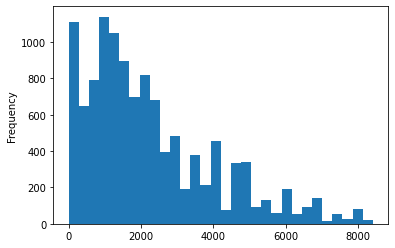

In [ ]:
valor_descarte_exp = data.EXPENSES.quantile(q = 0.75) + (1.5 * stats.iqr(data.EXPENSES, nan_policy = 'omit'))
valor_descarte_pr = data.PRICE_APROX_USD.quantile(q = 0.75) + (1.5 * stats.iqr(data.PRICE_APROX_USD, nan_policy = 'omit'))

data_expensas = data[(data.EXPENSES < valor_descarte_exp) & (data.PRICE_APROX_USD < valor_descarte_pr)]

data_expensas.EXPENSES.plot(kind = 'hist', bins = 30)

plt.show()

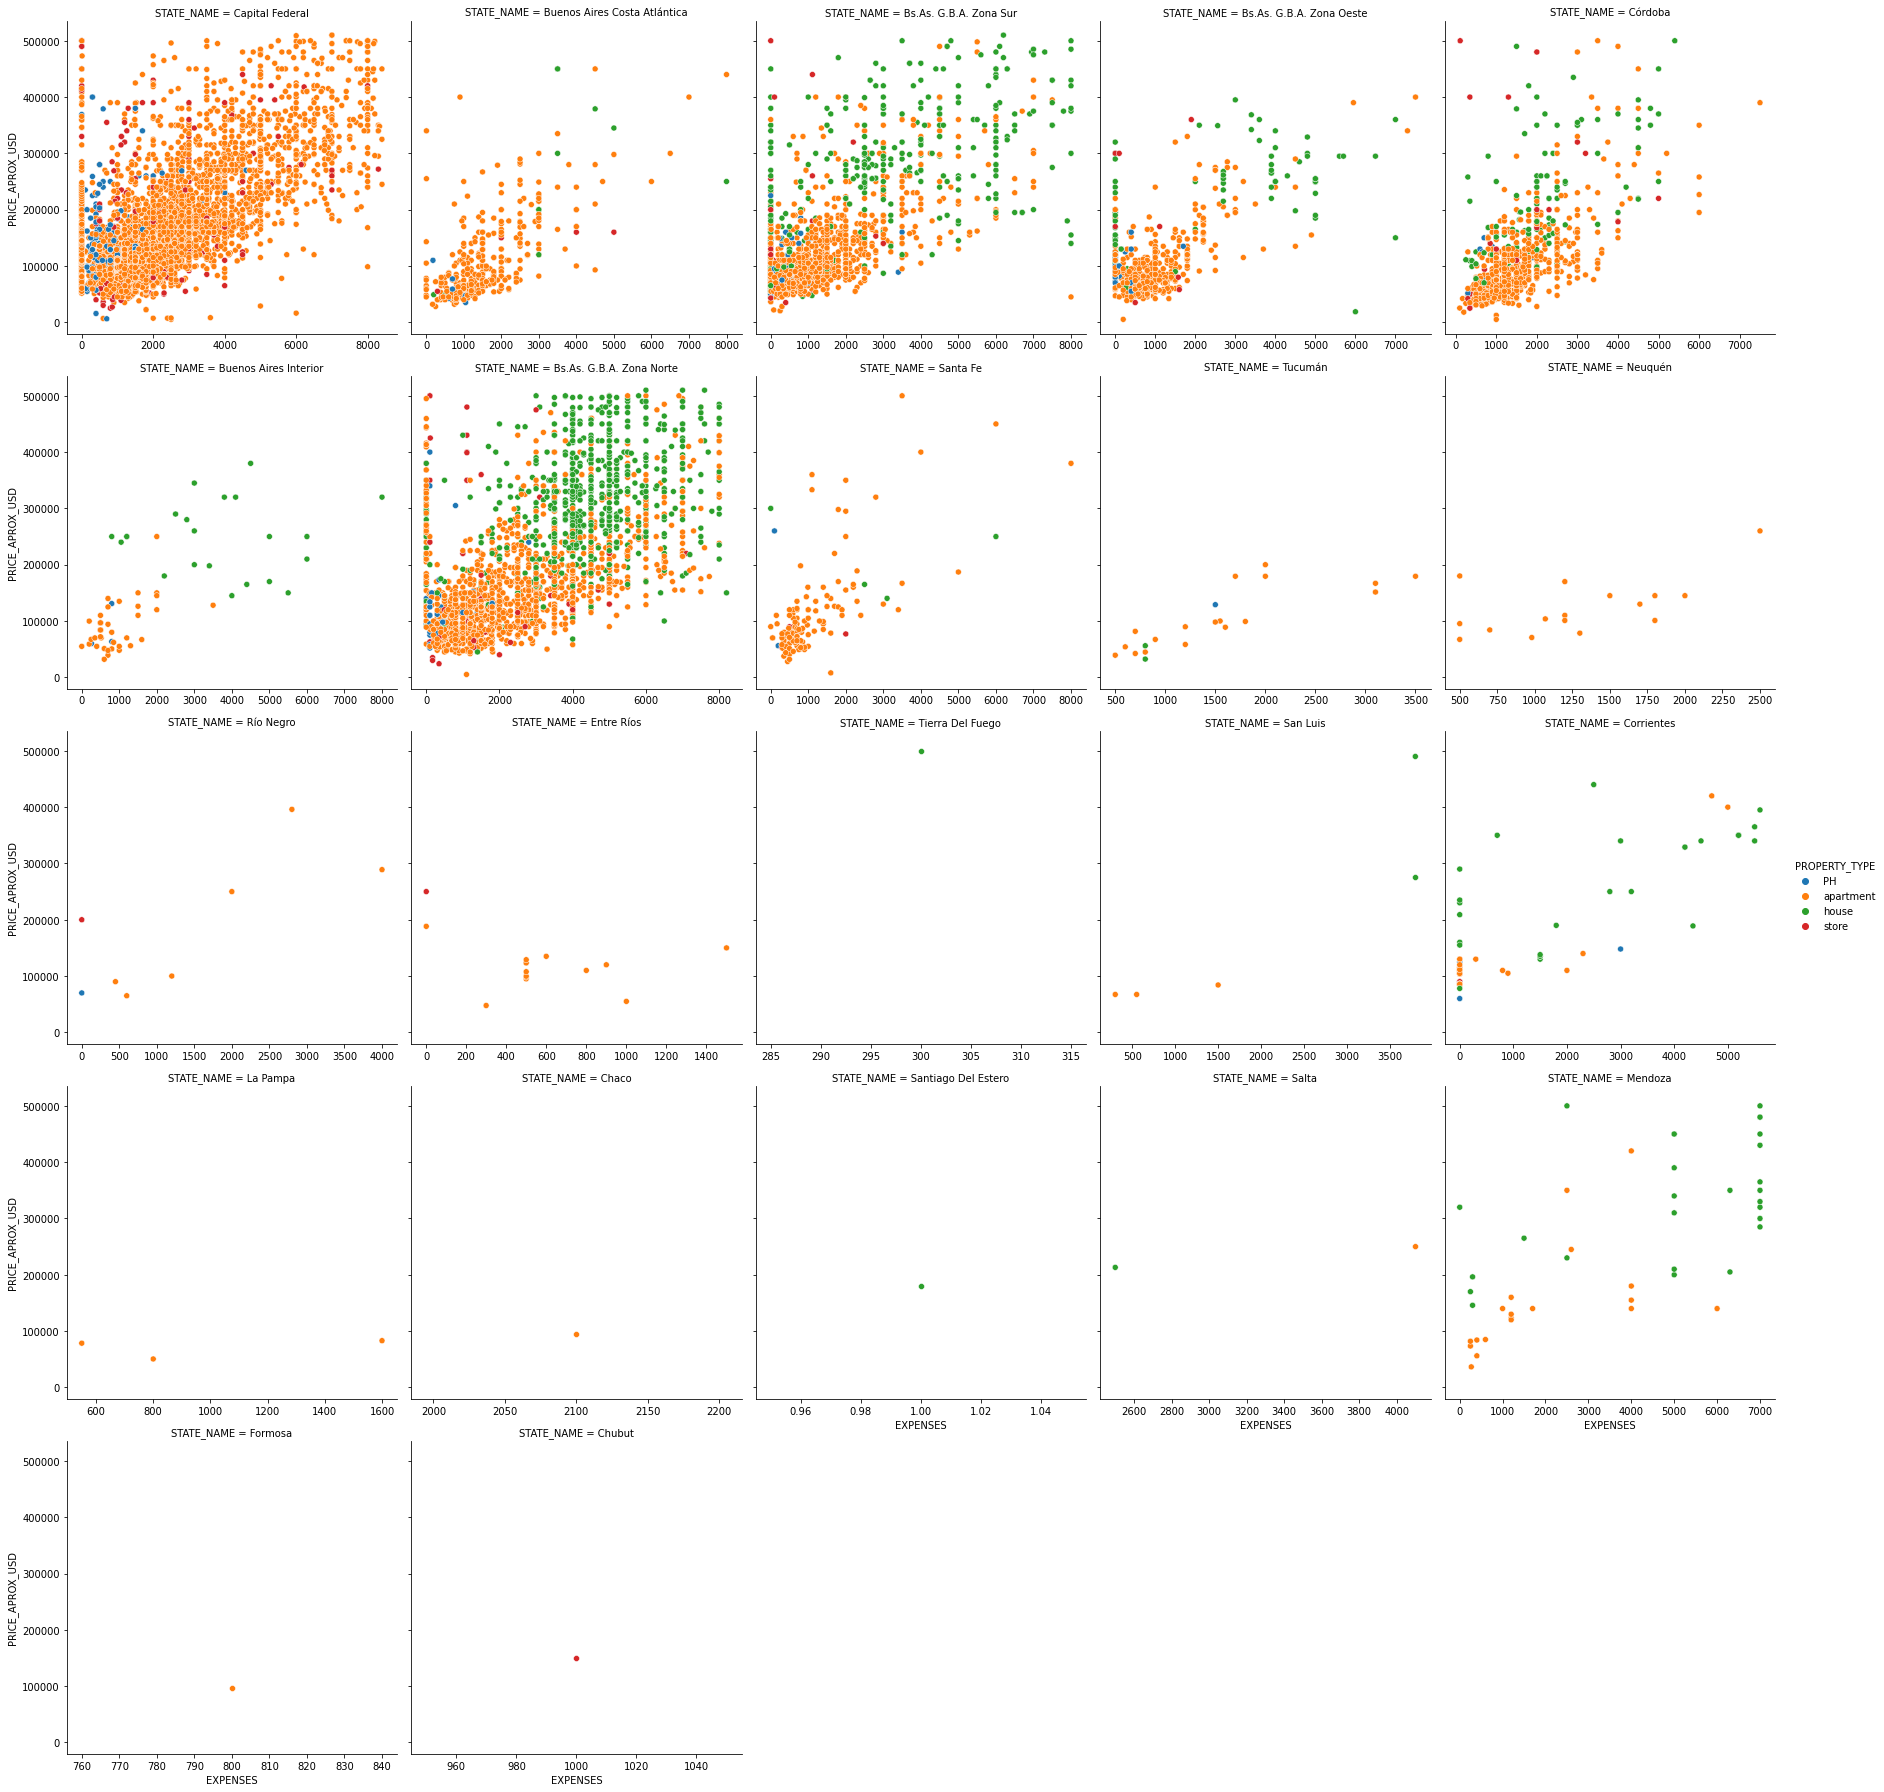

In [ ]:
sns.relplot(data = data_expensas, x = 'EXPENSES', y = 'PRICE_APROX_USD', col = 'STATE_NAME', 
            hue = 'PROPERTY_TYPE', col_wrap = 5, facet_kws = {'sharex' : False})
plt.show()

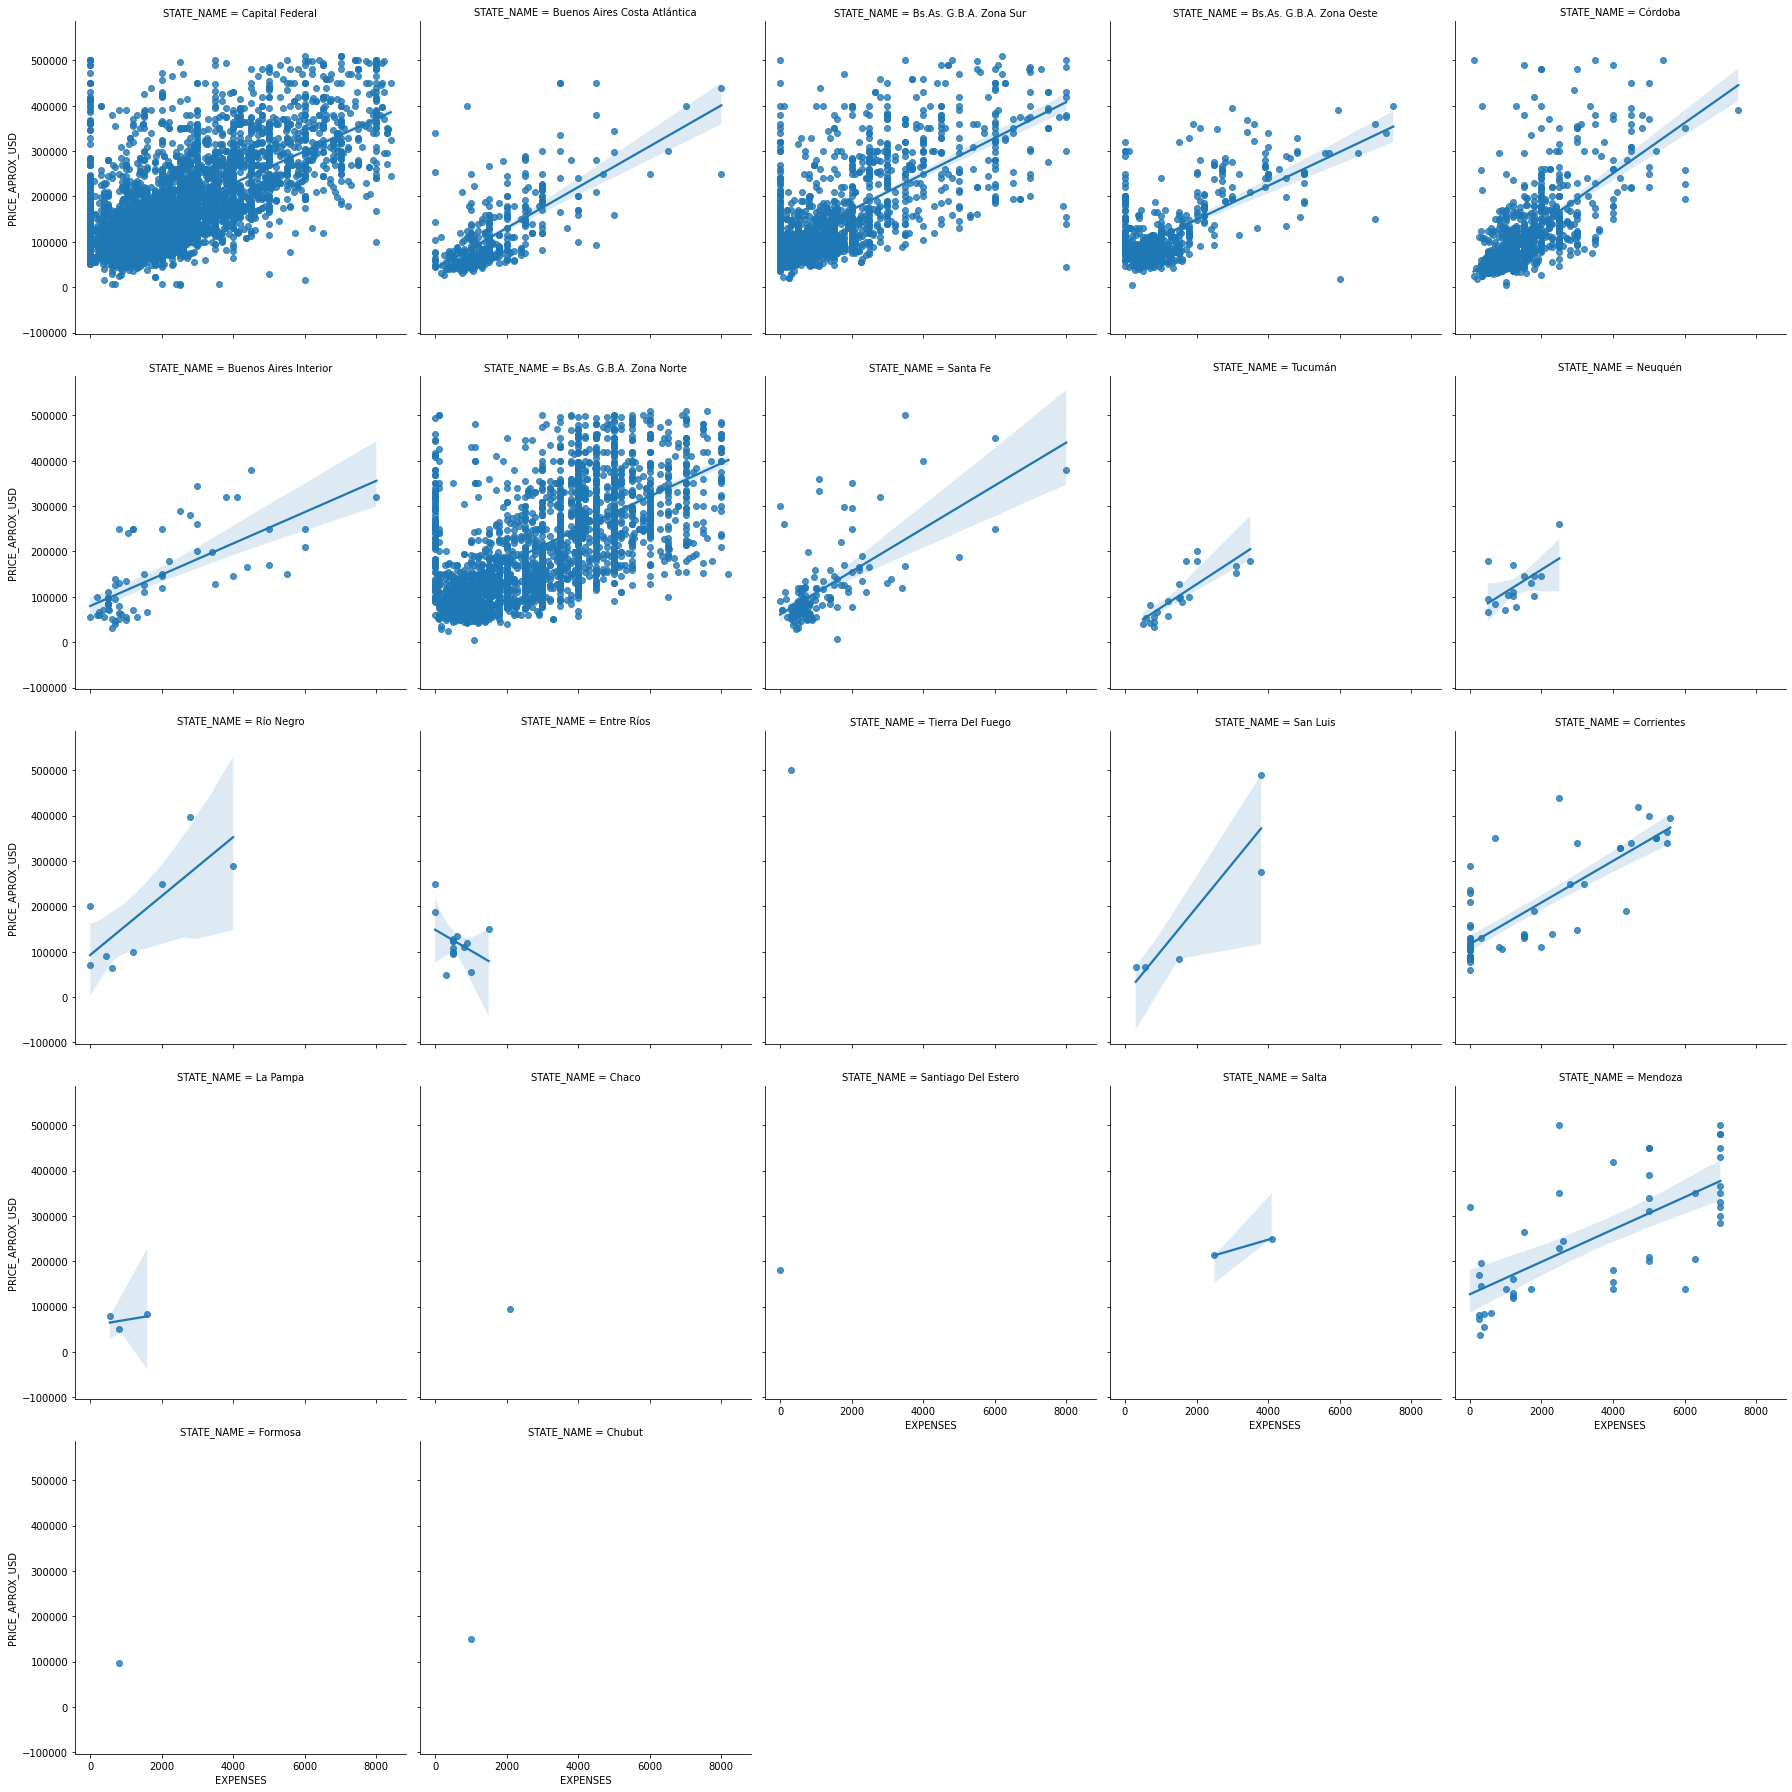

In [ ]:
sns.lmplot(data = data_expensas, x='EXPENSES', y = 'PRICE_APROX_USD', col = 'STATE_NAME', col_wrap = 5)

plt.show()

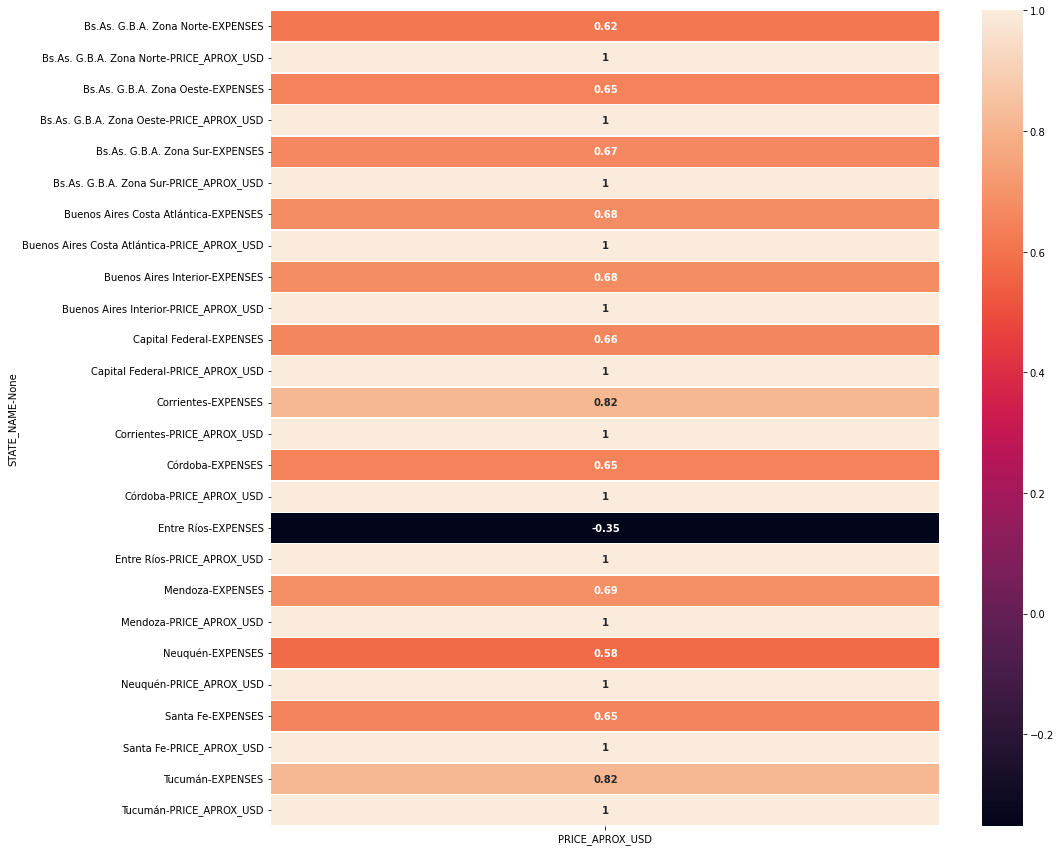

In [ ]:
corr_expensas = data_expensas.groupby('STATE_NAME')[['EXPENSES', 'PRICE_APROX_USD']].corr(min_periods = 10)
corr_expensas = corr_expensas.dropna().drop('EXPENSES', axis = 1)
# corr_expensas = corr_expensas.unstack()
# corr_expensas['EXPENSES']                          ACA ESTOY PROBANDO COSAS, DEJAR PARA DESPUÉS
fig, ax = plt.subplots(figsize = (15,15))
mapa_corr = sns.heatmap(corr_expensas, annot = True, ax = ax, linewidths=.5, annot_kws = {'fontweight': 'bold'})
plt.show()

Se observa una correlación mayor a 0.6 en gran parte de las provincias

Esto permitiría realizar algun tipo de imputación. Sin embargo, la complejidad de la tarea excede las posibilidades del presente trabajo, y por otra parte sería dificil no introducir demasiado ruido en esta variable.

Procederemos a dropearla más adelante

###**Variable lat-lon**

Aquí realizaremos una limpieza en tres etapas, rellenando nulos en base a información existente en el dataset y por último utilizando la API de *nominatim* que en base a una dirección, arroja las coordenadas de geolocalización.

In [ ]:
#create a column Province 
data['PROVINCIA']=data['STATE_NAME']
data.loc[data['STATE_NAME'].str.contains('Bs.As.|Buenos Aires', case=False, regex=True), 'PROVINCIA']='Buenos Aires'
#create a column that concatenate the values from  PROVINCIA CIUDAD BARRIO BARRIO_2

data['LOCALIZACION'] = data['BARRIO'].astype(str) +', '+ data['CIUDAD'].astype(str) +', '+data['PROVINCIA'].astype(str)
data['LOCALIZACION_2'] = data['CIUDAD'].astype(str) +', '+data['PROVINCIA'].astype(str)

#if the column LOCALIZACION, LOCALIZACION_2 and LOCALIZACION_3 starts with one or more , then replace it with ''
data['LOCALIZACION'] = data['LOCALIZACION'].str.replace(r'^(\s{0,1}\,)+\s{0,1}', '')
data['LOCALIZACION_2'] = data['LOCALIZACION_2'].str.replace(r'^(\s{0,1}\,)+\s{0,1}', '')

data['GEONAMES_ID'].fillna(data.groupby('LOCALIZACION')['GEONAMES_ID'].transform('first'), inplace=True)
data['GEONAMES_ID'].fillna(data.groupby('LOCALIZACION_2')['GEONAMES_ID'].transform('first'), inplace=True)

data['GEONAMES_ID'].fillna(data.groupby('PROVINCIA')['GEONAMES_ID'].transform('first'), inplace=True)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


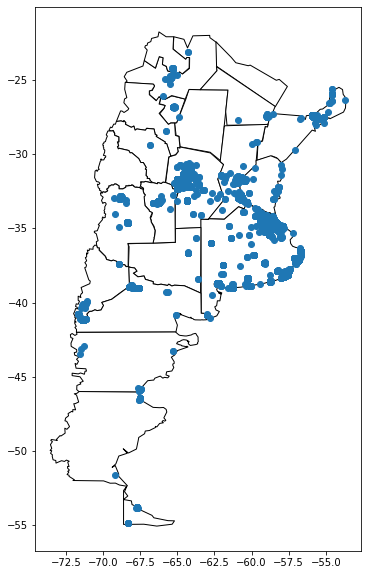

In [ ]:
#grafico 1
data=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.LON, data.LAT))
mapa_arg = gpd.read_file('/content/drive/MyDrive/TP 1 - GRUPO 5/ProvinciasArgentina.geojson')
fig, ax=plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
mapa_arg.plot(ax=ax, color='white', edgecolor='black')
data.plot(ax=ax)
plt.show()

In [ ]:
data.loc[~data['geometry'].is_empty, 'STAGE_COORD']='sin limpieza'

In [ ]:
#where lat-lon is null, fill with the value from lat where geonames_id is not null
data['LAT'].fillna(data.groupby('GEONAMES_ID').LAT.transform('first'), inplace = True)
data['LON'].fillna(data.groupby('GEONAMES_ID').LON.transform('first'), inplace = True)
data['LAT-LON'].fillna(data.groupby('GEONAMES_ID')['LAT-LON'].transform('first'), inplace = True)

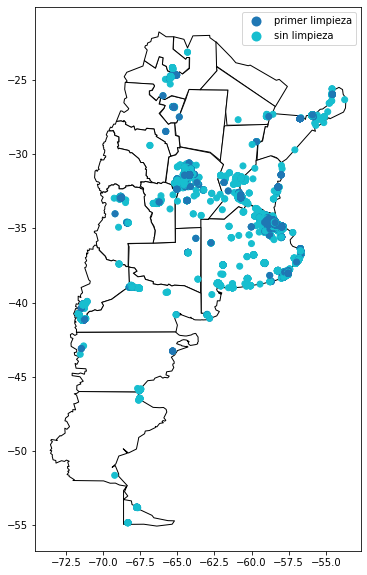

In [ ]:
data=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.LON, data.LAT))
data.loc[(~data['geometry'].is_empty) & (data['STAGE_COORD'].isna()), 'STAGE_COORD']='primer limpieza'
fig, ax=plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
mapa_arg.plot(ax=ax, color='white', edgecolor='black')
data.plot(ax=ax, column='STAGE_COORD', legend=True, alpha=1)
plt.show()

In [ ]:
print('La cantidad de nulos en la columna LAT-LON es', data['LAT-LON'].isna().sum())
print('La cantidad de nulos que quedan en las columnas de coordenadas no pueden ser rellenadas por GEONAMES_ID, dado que eso valores son', data.loc[data['LAT-LON'].isna() & data['LAT'].isna() & data['LON'].isna() & ~data['GEONAMES_ID'].isna()].shape[0], 'registros que no tienen coordenadas')

La cantidad de nulos en la columna LAT-LON es 718
La cantidad de nulos que quedan en las columnas de coordenadas no pueden ser rellenadas por GEONAMES_ID, dado que eso valores son 718 registros que no tienen coordenadas


In [ ]:
import requests
from tqdm import tqdm
#fill the nan values in LAT-LON requesting the coordinates to the API and if the value inn the columns contains BS AS
url='https://nominatim.openstreetmap.org/search?q={},Argentina&country=Argentina&format=json'
for col in ['LOCALIZACION', 'LOCALIZACION_2']:
    for i in tqdm(data.loc[data['LAT-LON'].isna() & data['LAT'].isna() & data['LON'].isna() & ~data['GEONAMES_ID'].isna()].index, desc='Iteracion sobre coordenadas nulas'):
        try:
            response = requests.get(url.format(data.loc[i, col]))
            if response.status_code == 200:
                #print(data.loc[i, col], response.json()[0]['lat'] + ',' + response.json()[0]['lon'])
                data.loc[i, 'LAT-LON'] = response.json()[0]['lat'] + ',' + response.json()[0]['lon']
                data.loc[i, 'LAT'] = response.json()[0]['lat']
                data.loc[i, 'LON'] = response.json()[0]['lon']
        except:
            pass
#convert the columns LAT LON LAT-LON to float
data['LAT']=data['LAT'].astype(float)
data['LON']=data['LON'].astype(float)

Iteracion sobre coordenadas nulas: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


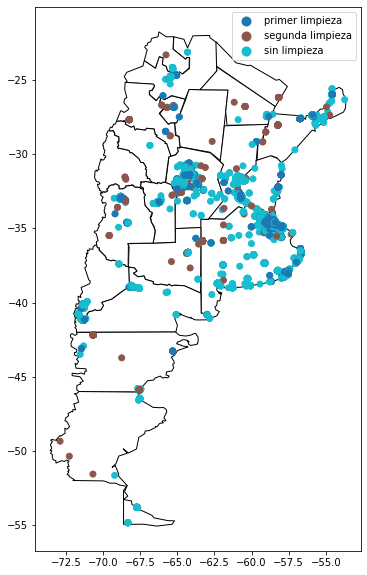

In [ ]:
data=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.LON, data.LAT))
data.loc[(~data['geometry'].is_empty) & (data['STAGE_COORD'].isna()), 'STAGE_COORD']='segunda limpieza'

fig, ax=plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
mapa_arg.plot(ax=ax, color='white', edgecolor='black')
data.plot(ax=ax, column='STAGE_COORD', legend=True, alpha=1)
plt.show()

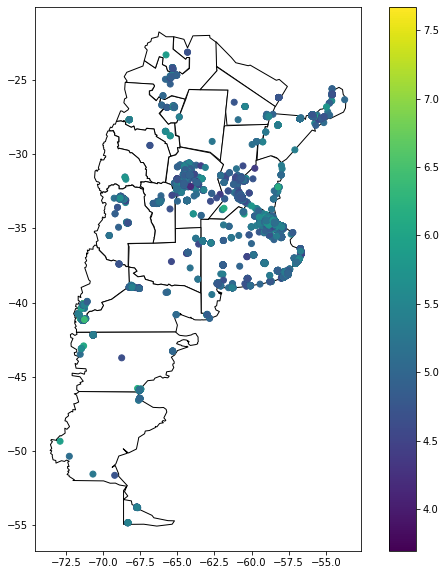

In [ ]:
#Mostramos distribución de los precios por localización

fig, ax=plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
mapa_arg.plot(ax=ax, color='white', edgecolor='black')
data.plot(ax=ax, column='LOG_PRICE_APROX_USD', legend=True, alpha=1)

plt.show()



In [ ]:
data = data.drop(['LOCALIZACION', 'LOCALIZACION_2', 'PROVINCIA', 'STAGE_COORD'], axis = 1)

## *2do paso intermedio: luego de la imputación de LAT y LON*

In [ ]:
data = data.drop('geometry', axis = 1)

In [ ]:
if crear_parquet:
    data.to_parquet(f'{ubicacion_dataset}properati_paso2.parquet')
else:
  data.to_csv(f'{ubicacion_dataset}properati_paso2.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  


Para comenzar a correr la notebook desde aquí, ejecutar esta celda

In [ ]:
# if crear_parquet:
#   data = pd.read_parquet(f'{ubicacion_dataset}properati_paso2.parquet')
# else:
#   data = pd.read_csv(f'{ubicacion_dataset}properati_paso2.csv', index_col = 0)

## **CREACIÓN DE NUEVAS FEATURES**

Creamos nuevas columnas 

```GARDEN``` y ```POOL```

que creemos pueden ser significativas para explicar el precio de la propiedad.

In [ ]:
#if the column url contains the word 'jardin' o 'patio', the value of the column 'GARDEN' is 1 otherwise 0
data['GARDEN']=0
data.loc[data['PROPERATI_URL'].str.contains('jardin|patio'), 'GARDEN']=1
data['POOL']=0
data.loc[data['PROPERATI_URL'].str.contains('pileta|piscina|piscin'), 'POOL']=1



In [ ]:
info_garden_pool = pd.DataFrame({'garden': data['GARDEN'].value_counts(), 'pool': data['POOL'].value_counts()})
info_garden_pool

garden   pool
0   69554  72235
1   28706  26025

## **LIMPIEZA FINAL**
Se quitan del dataset las columnas Floor y Expenses debido a que no se encontro un tratamiento para imputar valores que evite introducir ruido excesivo en los datos



In [ ]:
data.isna().sum()

PROPERTY_TYPE                     0
PLACE_NAME                        0
STATE_NAME                        0
GEONAMES_ID                       0
LAT-LON                           0
LAT                               0
LON                               0
PRICE                             0
CURRENCY                          0
PRICE_APROX_LOCAL_CURRENCY        0
PRICE_APROX_USD                   0
SURFACE_TOTAL_IN_M2           17886
SURFACE_COVERED_IN_M2          9642
PRICE_USD_PER_M2              17838
PRICE_PER_M2                   9322
FLOOR                         64226
ROOMS                         12020
EXPENSES                      85193
PROPERATI_URL                     0
DESCRIPTION                       2
TITLE                             0
CIUDAD                            0
BARRIO                         3574
CHEQUEO_PLACE                     0
CHEQUEO_UBICACION                 0
LOG_SURFACE_TOTAL_IN_M2       17886
LOG_SURFACE_COVERED_IN_M2      9642
RATIO_LOG_COVERED_TOTAL     

Dado que la columna ``EXPENSES`` y ``FLOOR`` no mostraron reducciones de los valores nulos con los métodos implementados decidimos dropearlas de nuestro dataset.



In [ ]:
data.drop(["EXPENSES","FLOOR"],axis=1, inplace=True)

Aquí, dropeamos columnas que fueron creadas auxiliarmente en el proceso de producción de limpieza, que ya no tendrán utilidad para los fines predictivos del dataset final.

In [ ]:
data = data.drop(['LAT-LON', 'CHEQUEO_PLACE',
       'CHEQUEO_UBICACION', 'LOG_SURFACE_TOTAL_IN_M2',
       'LOG_SURFACE_COVERED_IN_M2', 'RATIO_LOG_COVERED_TOTAL',
       'LOG_PRICE_APROX_USD', 'STAGE_SFT', 'STAGE_SFC'],axis=1)

Para la presencia de nulos en las columnas ``BARRIO`` y ``DESCRIPTION`` decidimos transformarlos en valores neutros ya que no creemos que sean valores tan relevantes que no lleven a dropear todo un registro completo del dataset, perdiendo información valiosa.  



In [ ]:
data.BARRIO = data.BARRIO.fillna('No aplica')
data.DESCRIPTION = data.DESCRIPTION.fillna('Sin descripción')

Por último, respecto a las posibles variables target que quedaron con valores nulos luego de todo el tratamiento realizado sobre las mismas, tomamos la decisión de dropear los registros. 

La eliminación de estos registros del dataset lo haremos en base a la variable ``SURFACE_COVERED_IN_M2``, por presentar la menor cantidad de nulos, y entonces contar con un dataset lo más amplio posible. Asimismo, esta decisión convierte a la variable ``PRICE_PER_M2`` en la target para nuestro modelo.

Con el resto de los nulos presentes en ``SURFACE_TOTAL_IN_M2`` y ``PRICE_USD_PER_M2``, temporalmente los reemplzaremos con un -9, para previo a enfrentar el TP II poder rellenarlos a través de inferencia estadísitca según características de la propiedad, considerando que pasan a ser variables explicativas del futuro modelo y no targets. 





In [ ]:
data.dropna(subset=['SURFACE_COVERED_IN_M2'], inplace=True)
data['SURFACE_TOTAL_IN_M2']=data['SURFACE_TOTAL_IN_M2'].fillna(-9)
data['PRICE_USD_PER_M2']=data['PRICE_USD_PER_M2'].fillna(-9)



---



In [ ]:
info_nulos_ok = pd.DataFrame({'nulos': data.isna().sum(), 'porcentaje' : (data.isna().sum()) / data.isna().count() * 100})


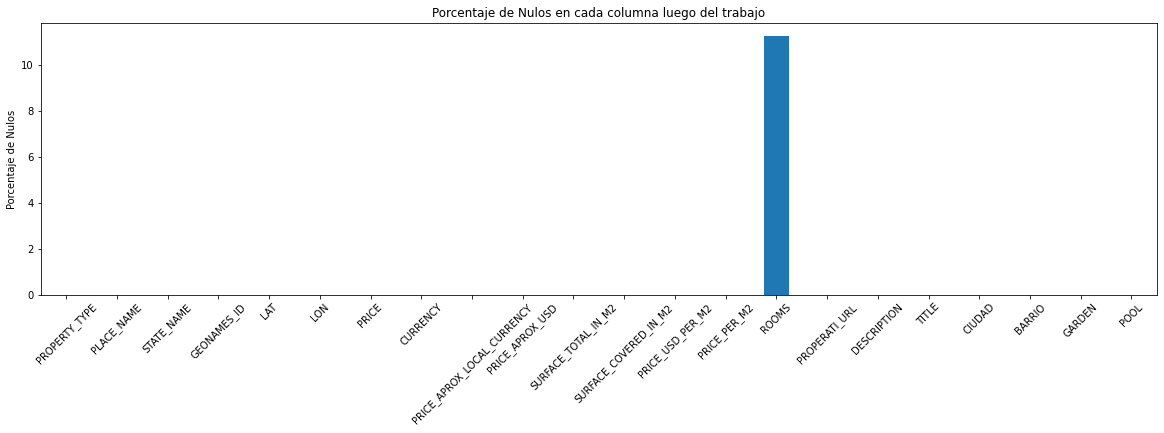

In [ ]:
info_nulos_ok.porcentaje.plot(kind = 'bar', figsize = (20, 5), rot = 45, title="Porcentaje de Nulos en cada columna luego del trabajo",
                              ylabel="Porcentaje de Nulos")

plt.show()

**ACLARACIÓN IMPORTANTE: por problemas con el colab perdimos una parte del código, donde se imputaban por bins los nulos de ROOMS faltantes. Al no llegar con el tiempo entregamos el trabajo así, luego será corregido**

# **PARA CONCLUIR, GUARDAMOS UNA COPIA DEL DATASET FINAL**

Reseteamos el Index y guardamos los originales

In [ ]:
data = data.reset_index()

In [ ]:
if crear_parquet:
    data.to_parquet(f'{ubicacion_dataset}properati_final.parquet')
else:
  data.to_csv(f'{ubicacion_dataset}properati_final.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  
